# 1. Setup

In [ ]:
! pip install holidays

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import holidays
import os
import csv
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# 2. Data extraction

## 2.1 Market energy price

The website that provided the data allowed me to download at most records from 31 days at once, so first i needed to combine them.

In [344]:
data_path = 'data/mep/'

dfs = []

for i in range(1, 61):
    file_path = os.path.join(data_path, f'{i}.csv')

    if os.path.exists(file_path):  
        df = pd.read_csv(file_path, sep = ';', encoding='ANSI')
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('data/mep/mep.csv', index=False)

In [19]:
data = pd.read_csv('data/mep/mep.csv', sep = ',',encoding='ANSI')
data['Data'] = pd.to_datetime(data['Data'], format='%Y%m%d')
data = data.rename(columns={'Godzina': 'Hour', 'Data': 'Date', 'RCE': 'MEP'})
print(data.info())
print(data.shape)
print(data.keys())

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    43824 non-null  datetime64[ns]
 1   Hour    43824 non-null  object        
 2   MEP     43824 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.0+ MB
None
(43824, 3)
Index(['Date', 'Hour', 'MEP'], dtype='object')


C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\3606877406.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


Date   Hour     MEP
count                 43824  43824   43824
unique                 1826     25   31663
top     2022-10-30 00:00:00      1  205,82
freq                     25   1826       8
first   2019-01-01 00:00:00    NaN     NaN
last    2023-12-31 00:00:00    NaN     NaN

I noticed that there were more than 24 unique values in the 'Hour' column. Further investigation proved that in the datasets (both the market price and the demand for energy) there were 5 records with '2A' as hour. No records were missing for those days, so i simply decided to remove those rows.

Similarly, there were 5 instances in both datasets with a missing record (on a completely different day than the 2A issue), i decided to fill it with data from adjacent rows.

In [20]:
unique_elements = data['Hour'].unique()

print(unique_elements)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '2A']


In [21]:
indices_with_2A = data[data['Hour'] == '2A'].index

print(indices_with_2A)

Int64Index([7177, 15913, 24817, 33553, 42289], dtype='int64')


In [22]:
data = data.drop(indices_with_2A)
data.reset_index(drop=True, inplace=True)

In [23]:
data['Hour'] = data['Hour'].astype(int)

In [24]:
def add_rows(indices, data):
    j = 0
    for i in indices:
        i += j
        new_row = pd.Series({'Date': pd.to_datetime(data.iloc[i]['Date']), 'Hour': (data.iloc[i]['Hour']-1), 'MEP': data.iloc[i]['MEP']})
        print(new_row)
        last_row = data.loc[len(data)-1]
        data.loc[i + 1:] = data.loc[i:].shift()
        data.loc[i] = new_row
        data = data.append(last_row, ignore_index=True)
        j += 1
    return data

In [25]:
time_diff = (data['Date'] - data['Date'].shift(1)).fillna(pd.Timedelta(seconds=0))
hour_diff = data['Hour'] - data['Hour'].shift(1)

mask = (time_diff == pd.Timedelta(days=0)) & (hour_diff != 1)

indices = np.where(mask)[0]

print(indices)

[    0  2137 10872 19607 28342 37077]


In [26]:
data = add_rows(indices[1:], data)

Date    2019-03-31 00:00:00
Hour                      2
MEP                  130,07
dtype: object
Date    2020-03-29 00:00:00
Hour                      2
MEP                   81,38
dtype: object
Date    2021-03-28 00:00:00
Hour                      2
MEP                  158,15
dtype: object
Date    2022-03-27 00:00:00
Hour                      2
MEP                  502,75
dtype: object
Date    2023-03-26 00:00:00
Hour                      2
MEP                  301,95
dtype: object


C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\364535730.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\364535730.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\364535730.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\364535730.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)


There were also 2 cases of weird encodings of the values.

In [27]:
data['MEP'] = data['MEP'].str.replace(',', '.')
data['MEP'] = data['MEP'].str.replace('Â\xa0', '')
try:
    data['MEP'] = data['MEP'].astype(float)
except ValueError as e:
    print(f"Error: {e}")

In [28]:
polish_holidays = holidays.Poland(years=[2019, 2020, 2021, 2022, 2023])
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfWeek'] = data.apply(lambda row: 6 if row['Date'].date() in polish_holidays or row['DayOfWeek'] == 6 else row['DayOfWeek'], axis=1)

## 2.2 Energy demand

In [29]:
data_path = 'data/demand/'

dfs = []

for i in range(1, 61):
    file_path = os.path.join(data_path, f'{i}.csv')

    if os.path.exists(file_path):  
        df = pd.read_csv(file_path, sep = ';', encoding='ANSI')
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

text_columns = combined_df.select_dtypes(include=['object']).columns
combined_df[text_columns] = combined_df[text_columns].replace({',': '.'}, regex=True)

combined_df.to_csv('data/demand/demand.csv', index=False, sep=';')

In [30]:
data2 = pd.read_csv('data/demand/demand.csv', sep=';',encoding='ANSI')
data2['Date'] = pd.to_datetime(data2['Date'], format='%Y%m%d')
data2 = data2.rename(columns={'Forecasted Day-ahead Total Load': 'Forecasted', 'Actual Total Load': 'Actual'})
print(data2.info())
print(data2.shape)
print(data2.keys())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        43824 non-null  datetime64[ns]
 1   Hour        43824 non-null  object        
 2   Forecasted  43824 non-null  int64         
 3   Actual      43824 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB
None
(43824, 4)
Index(['Date', 'Hour', 'Forecasted', 'Actual'], dtype='object')


In [31]:
data2.describe(include='all')

C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\2827009351.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data2.describe(include='all')


Date   Hour    Forecasted     Actual
count                 43824  43824  43824.000000      43824
unique                 1826     25           NaN      42804
top     2022-10-30 00:00:00      1           NaN  19425.050
freq                     25   1826           NaN          4
first   2019-01-01 00:00:00    NaN           NaN        NaN
last    2023-12-31 00:00:00    NaN           NaN        NaN
mean                    NaN    NaN  19724.565056        NaN
std                     NaN    NaN   3341.660672        NaN
min                     NaN    NaN  10600.000000        NaN
25%                     NaN    NaN  16943.000000        NaN
50%                     NaN    NaN  19900.000000        NaN
75%                     NaN    NaN  22302.000000        NaN
max                     NaN    NaN  27400.000000        NaN

In [32]:
unique_elements = data2['Hour'].unique()

print(unique_elements)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '2A']


In [33]:
indices_with_2A = data2[data2['Hour'] == '2A'].index

print(indices_with_2A)

Int64Index([7177, 15913, 24817, 33553, 42289], dtype='int64')


In [34]:
data2 = data2.drop(indices_with_2A)
data2.reset_index(drop=True, inplace=True)

In [35]:
data2['Hour'] = data2['Hour'].astype(int)

In [36]:
time_diff = (data2['Date'] - data2['Date'].shift(1)).fillna(pd.Timedelta(seconds=0))
hour_diff = data2['Hour'] - data2['Hour'].shift(1)

mask = (time_diff == pd.Timedelta(days=0)) & (hour_diff != 1)

indices = np.where(mask)[0]

print(indices)

[    0  2138 10873 19608 28343 37078]


In [37]:
def add_rows2(indices, data):
    j = 0
    for i in indices:
        i += j
        new_row = pd.Series({'Date': pd.to_datetime(data.iloc[i]['Date']), 'Hour': (data.iloc[i]['Hour']-1), 'Forecasted': data.iloc[i]['Forecasted'], 'Actual': data.iloc[i]['Actual']})
        print(new_row)
        last_row = data.loc[len(data)-1]
        data.loc[i + 1:] = data.loc[i:].shift()
        data.loc[i] = new_row
        data = data.append(last_row, ignore_index=True)
        j += 1
    return data

In [38]:
data2 = add_rows2(indices[1:], data2)

Date          2019-03-31 00:00:00
Hour                            3
Forecasted                  14300
Actual                  14209.638
dtype: object
Date          2020-03-29 00:00:00
Hour                            3
Forecasted                  13600
Actual                  13521.463
dtype: object
Date          2021-03-28 00:00:00
Hour                            3
Forecasted                  15000
Actual                  14870.588
dtype: object
Date          2022-03-27 00:00:00
Hour                            3
Forecasted                  15000
Actual                  15172.038
dtype: object
Date          2023-03-26 00:00:00
Hour                            3
Forecasted                  13677
Actual                  13756.963
dtype: object


C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\4250867037.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\4250867037.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\4250867037.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=True)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\4250867037.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(last_row, ignore_index=Tr

There were 2 instances with a missing actual demand, so i filled them with the value from the hour before.

In [39]:
indices_no_actual = data2[data2['Actual'] == '-'].index

print(indices_no_actual)

Int64Index([18526, 18527], dtype='int64')


In [40]:
def replace_actual(indices, df, column_name='Actual'):
    for idx in indices:
        if idx > 0:
            df.at[idx, column_name] = df.at[idx - 1, column_name]
    return df

In [41]:
data2 = replace_actual(indices_no_actual, data2)

In [42]:
data2['Actual'] = data2['Actual'].astype(float)

In [43]:
data = pd.merge(data, data2, on=['Date', 'Hour'], how='left')

In [44]:
data.describe(include='all')

C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\1336221646.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


Date          Hour           MEP     DayOfWeek  \
count                 43824  43824.000000  43824.000000  43824.000000   
unique                 1826           NaN           NaN           NaN   
top     2019-01-01 00:00:00           NaN           NaN           NaN   
freq                     24           NaN           NaN           NaN   
first   2019-01-01 00:00:00           NaN           NaN           NaN   
last    2023-12-31 00:00:00           NaN           NaN           NaN   
mean                    NaN     12.500000    426.714181      3.099124   
std                     NaN      6.922266    302.715775      2.030602   
min                     NaN      1.000000    -53.770000      0.000000   
25%                     NaN      6.750000    224.307500      1.000000   
50%                     NaN     12.500000    320.425000      3.000000   
75%                     NaN     18.250000    548.705000      5.000000   
max                     NaN     24.000000   3779.570000      6.000000   

          Forecasted        Actual  
count   43824.000000  43824.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
first            NaN           NaN  
last             NaN           NaN  
mean    19724.559419  19335.006650  
std      3341.674014   3228.687338  
min     10600.000000  10768.725000  
25%     16943.000000  16666.163000  
50%     19900.000000  19391.081500  
75%     22302.000000  21823.703500  
max     27400.000000  27374.675000

In [45]:
print(data.isna().any().any())

False


In [372]:
data.to_csv('data/full_data.csv', index=False)

# 3. Data analysis

In [324]:
data = pd.read_csv('data/full_data.csv', sep=',',encoding='ANSI')
data['Date'] = pd.to_datetime(data2['Date'], format='%Y%m%d')
print(data.info())
print(data.shape)
print(data.keys())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        43824 non-null  datetime64[ns]
 1   Hour        43824 non-null  int64         
 2   MEP         43824 non-null  float64       
 3   DayOfWeek   43824 non-null  int64         
 4   Forecasted  43824 non-null  int64         
 5   Actual      43824 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 2.0 MB
None
(43824, 6)
Index(['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'Actual'], dtype='object')


In [47]:
print(data.sort_values(by='MEP'))

            Date  Hour      MEP  DayOfWeek  Forecasted     Actual
43660 2023-12-25     5   -53.77          6       12008  13476.038
43659 2023-12-25     4   -51.02          6       11908  13542.938
43658 2023-12-25     3   -46.48          6       12258  13580.875
43661 2023-12-25     6   -44.83          6       12208  13570.138
43662 2023-12-25     7   -43.08          6       12658  13796.425
...          ...   ...      ...        ...         ...        ...
31939 2022-08-23    20  3373.26          1       22400  22087.913
32036 2022-08-27    21  3402.58          5       20050  19443.888
32156 2022-09-01    21  3435.07          3       22650  21967.213
31964 2022-08-24    21  3522.69          2       23150  22873.938
31940 2022-08-23    21  3779.57          1       22650  22590.825

[43824 rows x 6 columns]


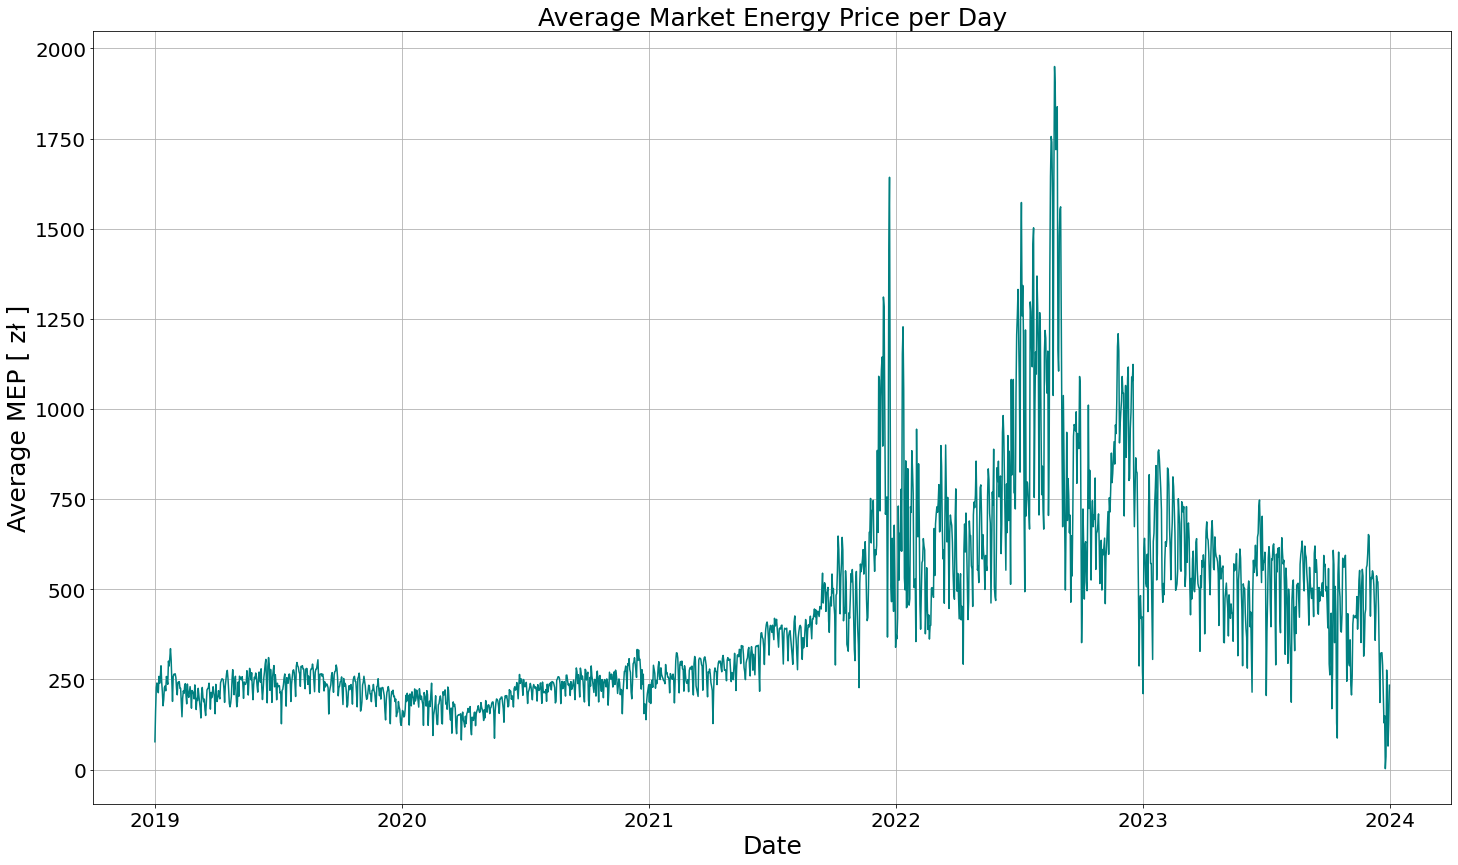

In [48]:
daily_avg_mep = data.groupby('Date')['MEP'].mean()

plt.figure(figsize=(20, 12))
plt.plot(daily_avg_mep.index, daily_avg_mep.values, linestyle='-', color='teal')
plt.title('Average Market Energy Price per Day', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Average MEP [ zł ]', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

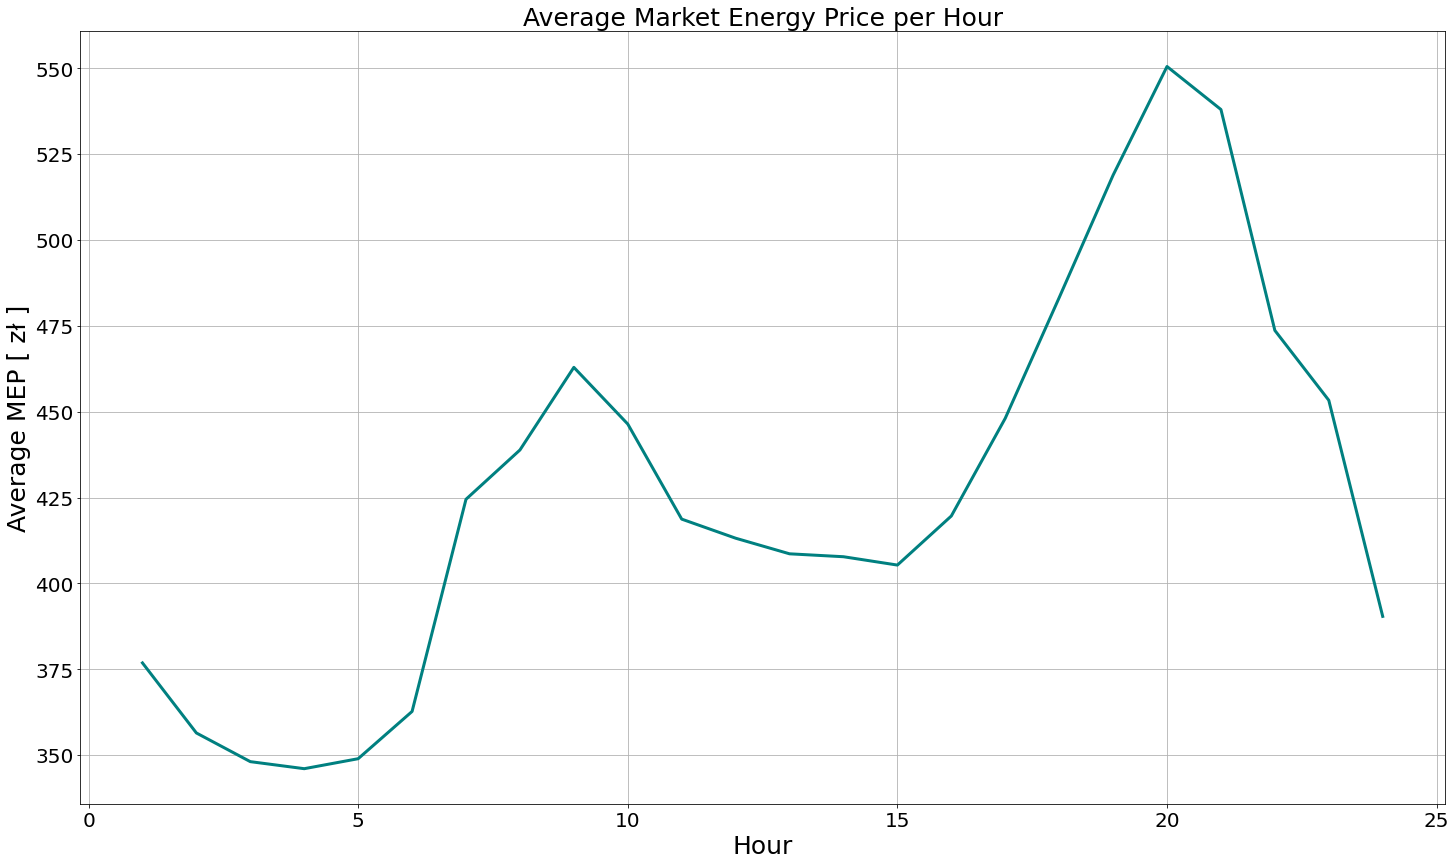

In [49]:
hourly_avg_mep = data.groupby('Hour')['MEP'].mean()

plt.figure(figsize=(20, 12))
plt.plot(hourly_avg_mep.index, hourly_avg_mep.values, linestyle='-', color='teal', linewidth=3)
plt.title('Average Market Energy Price per Hour', fontsize=25)
plt.xlabel('Hour', fontsize=25)
plt.ylabel('Average MEP [ zł ]', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

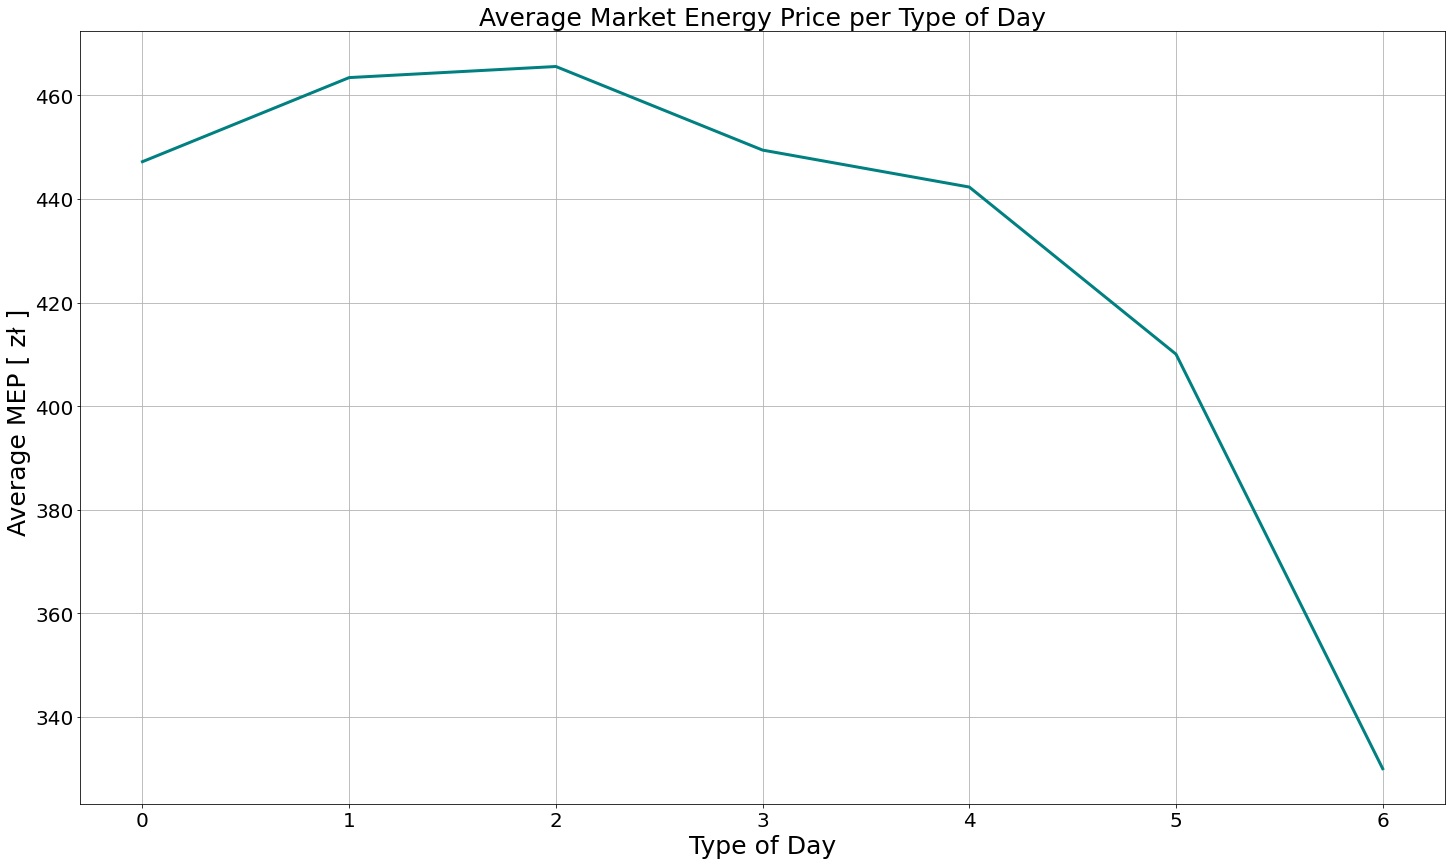

In [50]:
avg_mep_per_day_type = data.groupby('DayOfWeek')['MEP'].mean()

plt.figure(figsize=(20, 12))
plt.plot(avg_mep_per_day_type.index, avg_mep_per_day_type.values, linestyle='-', color='teal', linewidth=3)
plt.title('Average Market Energy Price per Type of Day', fontsize=25)
plt.xlabel('Type of Day', fontsize=25)
plt.ylabel('Average MEP [ zł ] ', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

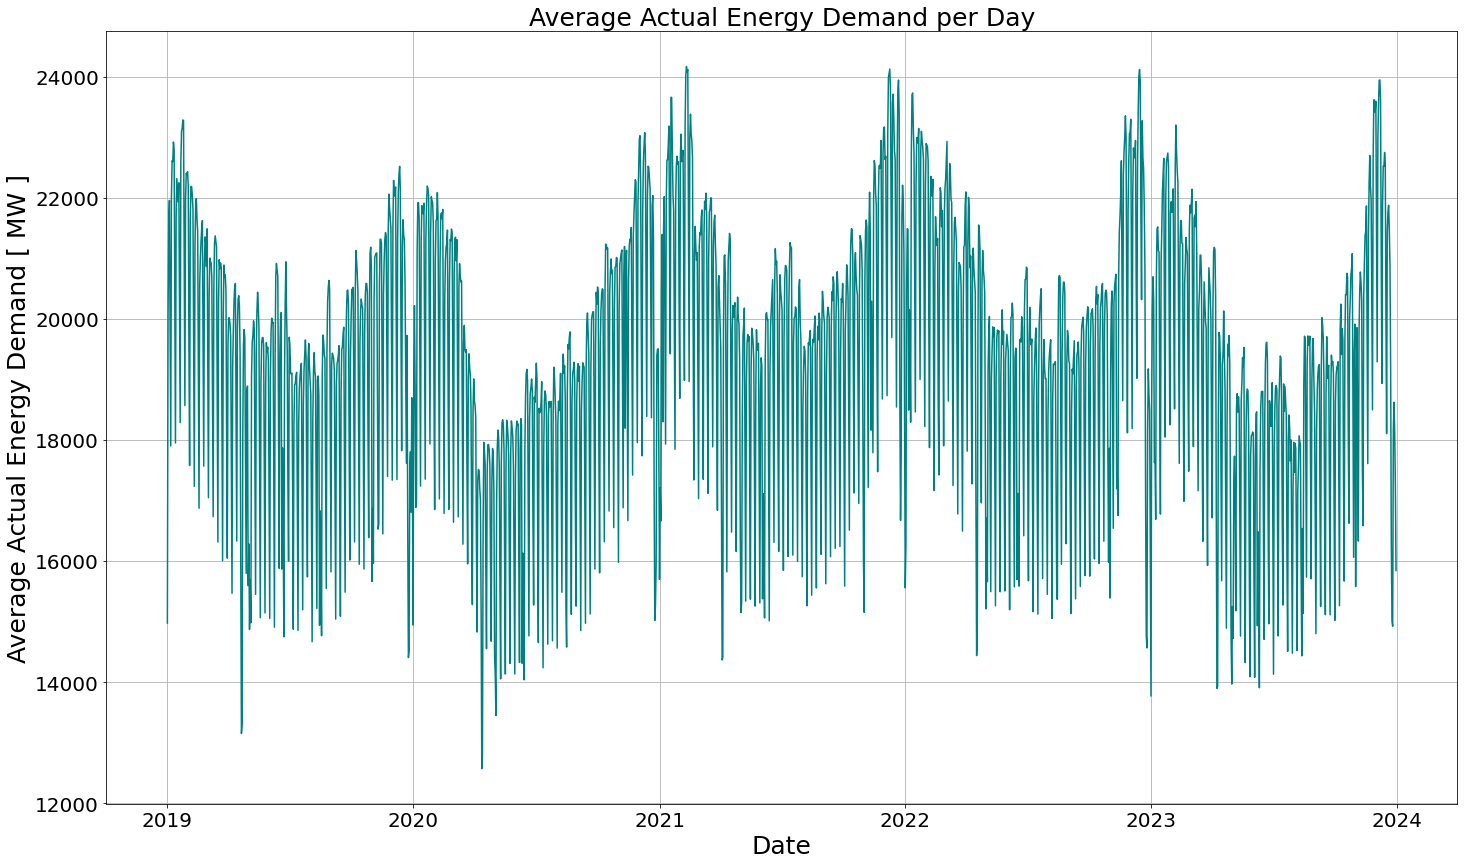

In [51]:
daily_avg_actual = data.groupby('Date')['Actual'].mean()

plt.figure(figsize=(20, 12))
plt.plot(daily_avg_actual.index, daily_avg_actual.values, linestyle='-', color='teal')
plt.title('Average Actual Energy Demand per Day', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Average Actual Energy Demand [ MW ]', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

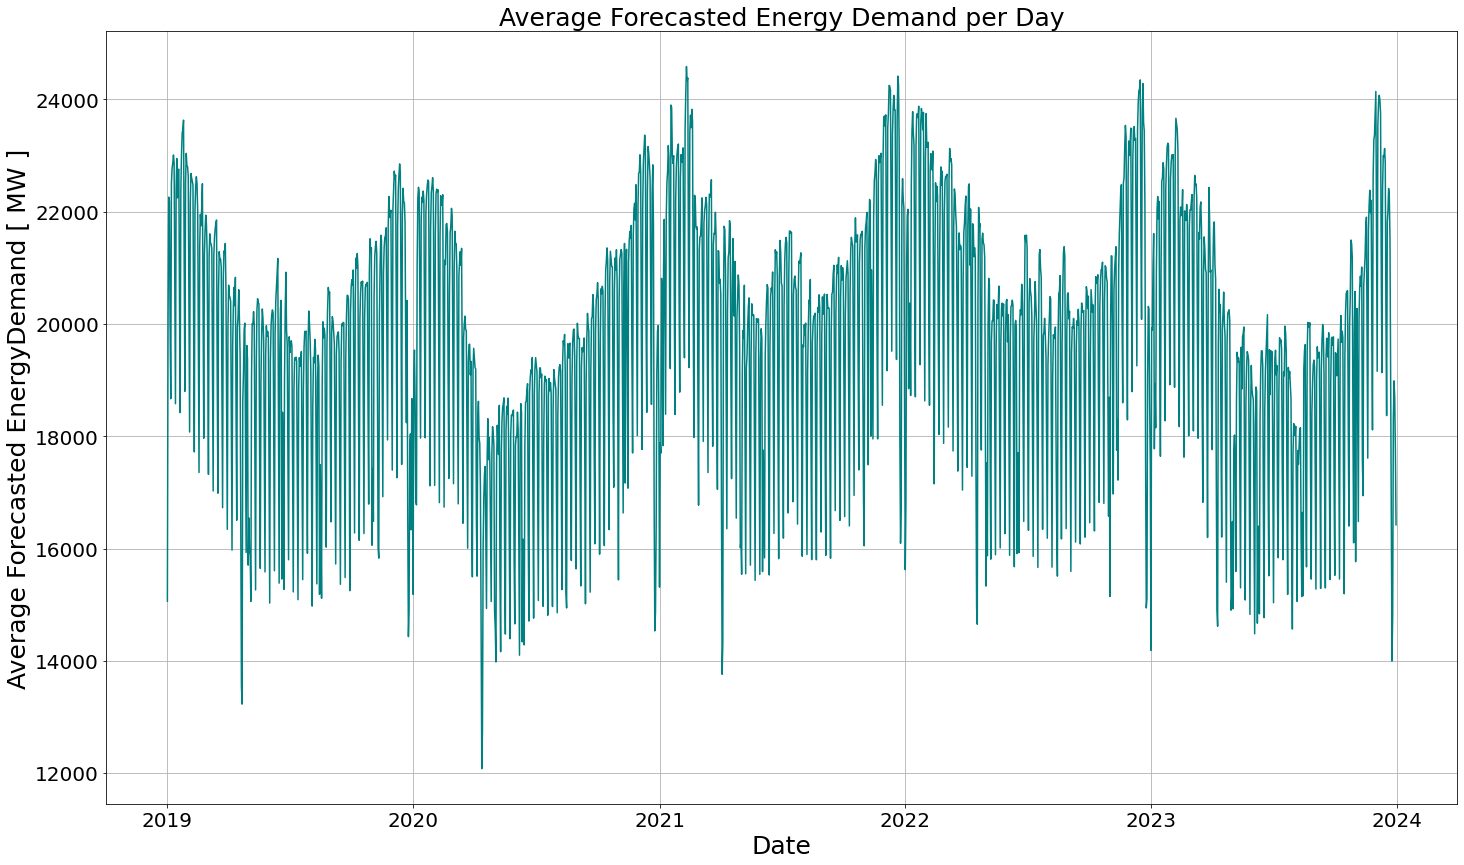

In [52]:
daily_avg_forecasted = data.groupby('Date')['Forecasted'].mean()

plt.figure(figsize=(20, 12))
plt.plot(daily_avg_forecasted.index, daily_avg_forecasted.values, linestyle='-', color='teal')
plt.title('Average Forecasted Energy Demand per Day', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Average Forecasted EnergyDemand [ MW ]', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# 4. Data preparation

## 4.1 Adding new variables

In [325]:
shift_hours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169]
for hours in shift_hours:
    data[f'MEP-{hours}'] = data['MEP'].shift(hours)

for hours in shift_hours:
    data[f'Actual-{hours}'] = data['Actual'].shift(hours)
for hours in shift_hours:
    data[f'Forecasted-{hours}'] = data['Forecasted'].shift(hours)

C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\1186047174.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Forecasted-{hours}'] = data['Forecasted'].shift(hours)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\1186047174.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Forecasted-{hours}'] = data['Forecasted'].shift(hours)
C:\Users\jihyo4\AppData\Local\Temp\ipykernel_7788\1186047174.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Linear correlation between the actual and predicted demand for energy

In [326]:
print(data['Forecasted'].corr(data['Actual']))

0.987117174645716


Value unknown at the moment of making the prediction

In [327]:
data = data.dropna()
data = data.drop(columns=['Actual'])

In [328]:
column_names = data.columns.tolist()

print(column_names)

['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-1', 'MEP-2', 'MEP-3', 'MEP-4', 'MEP-5', 'MEP-6', 'MEP-7', 'MEP-8', 'MEP-9', 'MEP-10', 'MEP-11', 'MEP-12', 'MEP-15', 'MEP-18', 'MEP-21', 'MEP-23', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-95', 'MEP-96', 'MEP-97', 'MEP-119', 'MEP-120', 'MEP-121', 'MEP-143', 'MEP-144', 'MEP-145', 'MEP-167', 'MEP-168', 'MEP-169', 'Actual-1', 'Actual-2', 'Actual-3', 'Actual-4', 'Actual-5', 'Actual-6', 'Actual-7', 'Actual-8', 'Actual-9', 'Actual-10', 'Actual-11', 'Actual-12', 'Actual-15', 'Actual-18', 'Actual-21', 'Actual-23', 'Actual-24', 'Actual-25', 'Actual-47', 'Actual-48', 'Actual-49', 'Actual-71', 'Actual-72', 'Actual-73', 'Actual-95', 'Actual-96', 'Actual-97', 'Actual-119', 'Actual-120', 'Actual-121', 'Actual-143', 'Actual-144', 'Actual-145', 'Actual-167', 'Actual-168', 'Actual-169', 'Forecasted-1', 'Forecasted-2', 'Forecasted-3', 'Forecasted-4', 'Forecasted-5', 'Forecasted-6', 'Forecasted-7', 'Forecast

Checking which variables are potentially import and worth using

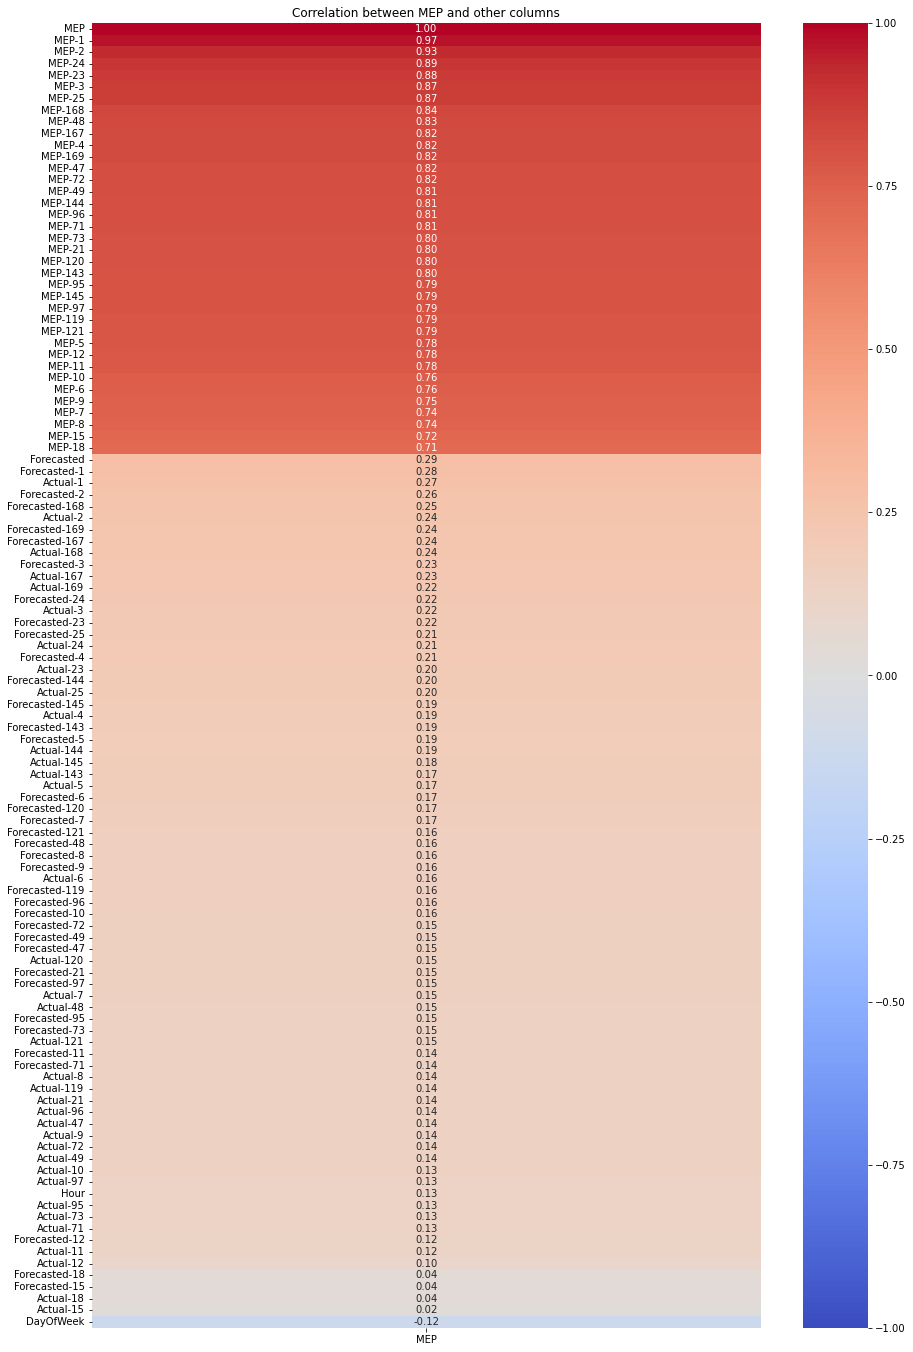

In [174]:
corr_matrix = data.corr()

mep_correlations = corr_matrix[['MEP']].sort_values(by='MEP', ascending=False)

plt.figure(figsize=(15, 24))
sns.heatmap(mep_correlations, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between MEP and other columns')
plt.show()

In [329]:
selected_columns = ['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-1', 'MEP-2', 'MEP-3', 'MEP-4', 'MEP-23', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-96', 'MEP-144', 'MEP-167', 'MEP-168', 'MEP-169', 'Actual-1', 'Forecasted-1', 'Forecasted-2', 'Forecasted-168']
data = data[selected_columns]

## 4.2 Split the data

In [330]:
start_date = data['Date'].min()
data.loc[:, 'Weeks_Since_Start'] = (data['Date'] - start_date).dt.days // 7

data.loc[:, 'Cycle_Group'] = data['Weeks_Since_Start'] // 6

data.loc[:, 'Week_In_Cycle'] = data['Weeks_Since_Start'] % 6

data.loc[:, 'Set'] = 0
data.loc[data['Week_In_Cycle'] == 4, 'Set'] = 1
data.loc[data['Week_In_Cycle'] == 5, 'Set'] = 2

data = data.drop(columns=['Cycle_Group', 'Week_In_Cycle'])
selected_columns = ['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-1', 'MEP-2', 'MEP-3', 'MEP-4', 'MEP-23', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-96', 'MEP-144', 'MEP-167', 'MEP-168', 'MEP-169', 'Actual-1', 'Forecasted-1', 'Forecasted-2', 'Forecasted-168']
data = data[selected_columns]

In [331]:
df = data[['Set', 'Date', 'MEP', 'Hour', 'DayOfWeek', 'Forecasted', 'Actual-1', 'MEP-1', 'MEP-2', 'MEP-3', 'MEP-4', 'MEP-23', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-96', 'MEP-144', 'MEP-167', 'MEP-168', 'MEP-169', 'Forecasted-1', 'Forecasted-2', 'Forecasted-168']]
df.to_excel('data.xlsx', index=False)

In [332]:
Y = data[['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'MEP']]
X = data[['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'DayOfWeek', 'Forecasted', 'MEP-1', 'MEP-2', 'MEP-3', 'MEP-4', 'MEP-23', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-96', 'MEP-144', 'MEP-167', 'MEP-168', 'MEP-169', 'Actual-1', 'Forecasted-1', 'Forecasted-2', 'Forecasted-168']]

In [333]:
Y_train = Y[Y['Set'] == 0].drop(columns=['Set'])
Y_val = Y[Y['Set'] == 1].drop(columns=['Set'])
Y_test = Y[Y['Set'] == 2].drop(columns=['Set'])
X_train = X[X['Set'] == 0].drop(columns=['Set'])
X_val = X[X['Set'] == 1].drop(columns=['Set'])
X_test = X[X['Set'] == 2].drop(columns=['Set'])

In [334]:
y_train = Y_train['MEP']
y_test = Y_test['MEP']
y_val = Y_val['MEP']
x_train = X_train.iloc[:, 2:]
x_test = X_test.iloc[:, 2:]
x_val = X_val.iloc[:, 2:]

# 5. Model training

In [181]:
def decision_tree(param_grid, x_train, x_val, y_train, y_val):
    st = time.time()
    
    dt = DecisionTreeRegressor(random_state=42)
    cv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                               cv=cv, n_jobs=-1, verbose=3, scoring='neg_mean_squared_error')

    grid_search.fit(x_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    best_dt = grid_search.best_estimator_
    
    best_dt.fit(pd.concat([x_train, x_val]), pd.concat([y_train, y_val]))

    y_pred_dt = best_dt.predict(x_test)
    y_pred_series = pd.Series(y_pred_dt, index=X_test.index)
    
    et = time.time()
    print('Execution time:', et - st, 'seconds')

    return pd.concat([X_test['Weeks_Since_Start'], y_pred_series], axis=1), y_pred_dt, best_dt, grid_search

In [182]:
param_grid = {
        'max_depth': [11, 12, 13, 15],
        'min_samples_split': [14, 16, 20, 30],
        'min_samples_leaf': [10, 12, 18],
        'criterion': ['squared_error', 'friedman_mse'],
        'max_features': [0.6, 0.7, 0.8, 0.9],
        'max_leaf_nodes': [800, 1000, 1200, 1400]
}
y_pred_dt_df, y_pred_dt, best_dt, grid_dt = decision_tree(param_grid, x_train, x_val, y_train, y_val) 

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 11, 'max_features': 0.8, 'max_leaf_nodes': 800, 'min_samples_leaf': 12, 'min_samples_split': 30}
Execution time: 88.62507343292236 seconds


In [184]:
def random_forest(param_grid, x_train, x_val, y_train, y_val):
    st = time.time()
    
    rf = RandomForestRegressor(random_state=42)
    #cv = KFold(n_splits=4, shuffle=True, random_state=42)
    cv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')

    grid_search.fit(x_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    best_rf = grid_search.best_estimator_

    best_rf.fit(pd.concat([x_train, x_val]), pd.concat([y_train, y_val]))

    y_pred_rf = best_rf.predict(x_test)
    y_pred_rf_series = pd.Series(y_pred_rf, index=x_test.index)
    
    et = time.time()
    print('Execution time:', et - st, 'seconds')

    return pd.concat([X_test['Weeks_Since_Start'], y_pred_rf_series], axis=1), y_pred_rf, best_rf, grid_search

In [190]:
param_grid = {
    'n_estimators': [160, 200],
    'max_depth': [10, 11, 12],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [3, 5, 6],
    'criterion': ['squared_error'],
    'max_features': [0.5, 0.55, 0.6],
    'max_leaf_nodes': [600, 800, 1000],
    'max_samples': [0.55, 0.6]
}
y_pred_rf_df, y_pred_rf, best_rf, grid_rf = random_forest(param_grid, x_train, x_val, y_train, y_val)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 11, 'max_features': 0.6, 'max_leaf_nodes': 1000, 'max_samples': 0.6, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 160}
Execution time: 3118.182332277298 seconds


In [194]:
grid_rf.cv_results_

{'mean_fit_time': array([ 9.6325802 , 12.00488448, 10.01003702, 12.29172802, 10.1657064 ,
        12.55583811, 10.36883815, 12.41110118,  9.77623399, 12.4316086 ,
         9.79038572, 12.52006578,  9.84820485, 12.38091938,  9.8607804 ,
        12.37473178, 10.32026617, 12.63797553, 11.33493431, 13.80398862,
        10.92619236, 13.87320256, 10.93252118, 13.98678644, 11.01259184,
        13.69954332, 11.6360631 , 14.24240915, 11.62439426, 14.06269566,
        11.08870459, 14.03395041, 11.31034509, 14.01149297, 11.28601956,
        14.0323995 , 11.05233836, 13.97606222, 11.13421551, 14.07797241,
        11.03631941, 13.88962285, 10.84582575, 14.11863748, 11.44501495,
        13.94413431, 11.03496607, 13.85233847, 11.04308248, 14.06674536,
        10.8625354 , 14.12123394, 11.2580448 , 13.96158401, 12.04652516,
        15.48469162, 12.39519175, 15.06861798, 12.02262322, 15.09047969,
        11.70267216, 15.00360775, 11.97104518, 14.86997843, 12.1203831 ,
        14.79142229, 11.68132861, 

# 6. Model comparison

## 6.1 Auxiliary functions

In [254]:
def mse(df, actual_col, predicted_col):
    return np.mean((df[actual_col] - df[predicted_col]) ** 2)

def rmse(df, actual_col, predicted_col):
    return np.sqrt(mse(df, actual_col, predicted_col))

def mae(df, actual_col, predicted_col):
    return np.mean(np.abs(df[actual_col] - df[predicted_col]))

def mape(df, actual_col, predicted_col):
    df = df[df[actual_col] != 0]
    return np.mean(np.abs((df[actual_col] - df[predicted_col]) / df[actual_col])) * 100

In [255]:
def score_the_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    return mse, rmse, mae, mape

In [256]:
def plot_prediction(Y, X, week_number, title):
    Y_week = Y[X['Weeks_Since_Start'] == week_number]
    X_week = X[X['Weeks_Since_Start'] == week_number]
    
    if len(Y_week) == 0 or len(X_week) == 0:
        print("No data available for the specified week.")
        return

    datetime_series = pd.to_datetime(Y_week['Date']) + pd.to_timedelta(Y_week['Hour'], unit='h')
    plt.figure(figsize=(12, 8))
    plt.plot(datetime_series, Y_week['MEP'], label='Real prices', color='blue')
    plt.plot(datetime_series, X_week.iloc[:, 1], label='Predicted prices', color='red')
    plt.title(f'{title} for Week {week_number}', fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Price [ zł ]', fontsize=25)
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

In [257]:
def plot_comparison(Y, N, D, R, week_number, title):
    con = pd.concat([Y, N, D, R], axis=1)
    con = con[con['Weeks_Since_Start'] == week_number]
    
    if len(con) == 0 or len(con) == 0:
        print("No data available for the specified week.")
        return

    datetime_series = pd.to_datetime(con['Date']) + pd.to_timedelta(con['Hour'], unit='h')
    plt.figure(figsize=(12, 8))
    plt.plot(datetime_series, con['MEP'], label='Real prices', color='blue')
    plt.plot(datetime_series, con.iloc[:, 4], label='Naive predictor', color='red')
    plt.plot(datetime_series, con.iloc[:, 5], label='Best decision tree', color='purple')
    plt.plot(datetime_series, con.iloc[:, 6], label='Best random forest', color='green')
    plt.title(f'{title} for Week {week_number}', fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Price [ zł ]', fontsize=25)
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

In [258]:
def plot_time_comparison(Y, hour, day, week_number, title):
    con = pd.concat([Y, hour, day], axis=1)
    con = con[con['Weeks_Since_Start'] == week_number]
    
    if len(con) == 0 or len(con) == 0:
        print("No data available for the specified week.")
        return

    datetime_series = pd.to_datetime(con['Date']) + pd.to_timedelta(con['Hour'], unit='h')
    plt.figure(figsize=(12, 8))
    plt.plot(datetime_series, con['MEP'], label='Real prices', color='blue')
    plt.plot(datetime_series, con.iloc[:, 4], label='Prediction 1 hour ahead', color='red')
    plt.plot(datetime_series, con.iloc[:, 5], label='Prediction 1 day ahead', color='green')
    plt.title(f'{title} for Week {week_number}', fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Price [ zł ]', fontsize=25)
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

In [319]:
def compare_model_performance(y_true, y_pred1, y_pred2, y_pred3):
    mse1, rmse1, mae1, mape1 = score_the_model(y_true, y_pred1)
    mse2, rmse2, mae2, mape2 = score_the_model(y_true, y_pred2)
    mse3, rmse3, mae3, mape3 = score_the_model(y_true, y_pred3)

    mses = [mse1, mse2, mse3]
    rmses = [rmse1, rmse2, rmse3]
    maes = [mae1, mae2, mae3]
    mapes = [mape1, mape2, mape3]
    labels = ['Naive predictor', 'Best decision tree', 'Best random forest']

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    axs[0, 0].bar(labels, mses, color=['blue', 'green', 'red'])
    axs[0, 0].set_title('MSE Comparison', fontsize=20)
    axs[0, 0].set_ylabel('MSE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[0, 1].bar(labels, rmses, color=['blue', 'green', 'red'])
    axs[0, 1].set_title('RMSE Comparison', fontsize=20)
    axs[0, 1].set_ylabel('RMSE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[1, 0].bar(labels, maes, color=['blue', 'green', 'red'])
    axs[1, 0].set_title('MAE Comparison', fontsize=20)
    axs[1, 0].set_ylabel('MAE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[1, 1].bar(labels, mapes, color=['blue', 'green', 'red'])
    axs[1, 1].set_title('MAPE Comparison', fontsize=20)
    axs[1, 1].set_ylabel('MAPE', fontsize=20)
    plt.yticks(fontsize=15)

    plt.tight_layout()
    plt.show()

In [322]:
def compare_model_performance_time(y_true, y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6):
    metrics = [score_the_model(y_true, y_pred) for y_pred in [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]]
    
    mses, rmses, maes, mapes = zip(*metrics)

    labels = ['Naive hour', 'Tree hour', 'Forest hour', 'Naive day', 'Tree day', 'Forest day']
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].bar(labels, mses, color=colors)
    axs[0, 0].set_title('MSE Comparison', fontsize=20)
    axs[0, 0].set_ylabel('MSE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[0, 1].bar(labels, rmses, color=colors)
    axs[0, 1].set_title('RMSE Comparison', fontsize=20)
    axs[0, 1].set_ylabel('RMSE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[1, 0].bar(labels, maes, color=colors)
    axs[1, 0].set_title('MAE Comparison', fontsize=20)
    axs[1, 0].set_ylabel('MAE', fontsize=20)
    plt.yticks(fontsize=15)

    axs[1, 1].bar(labels, mapes, color=colors)
    axs[1, 1].set_title('MAPE Comparison', fontsize=20)
    axs[1, 1].set_ylabel('MAPE', fontsize=20)
    plt.yticks(fontsize=15)

    plt.tight_layout()
    plt.show()

In [302]:
def plot_importances(best_model, x_train):
    importances = best_model.feature_importances_

    # Get the feature names
    feature_names = x_train.columns

    # Sort the feature importances in descending order and match them with feature names
    indices = np.argsort(importances)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances", fontsize=25)
    plt.bar(range(x_train.shape[1]), importances[indices], align="center", color=sns.color_palette("viridis", x_train.shape[1]))
    plt.xticks(range(x_train.shape[1]), sorted_feature_names, rotation=45, ha='right', fontsize=12)
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Importance", fontsize=20)
    plt.tight_layout()
    plt.show()

## 6.2 Results

In [203]:
print('Naive predictor:')
print(score_the_model(Y_test['MEP'], X_test['MEP-1']))
print('Best decision tree:')
print(score_the_model(y_test, y_pred_dt))
print('Best random forest:')
print(score_the_model(y_test, y_pred_rf))

Naive predictor:
(3707.822468715393, 60.89189165000044, 29.27292912513843, 6.512799234768655)
Best decision tree:
(3264.999836152115, 57.14017707491039, 27.284047576464964, 6.248727695533174)
Best random forest:
(1924.4255174161917, 43.8682746117988, 21.858982682363383, 5.333807640273185)


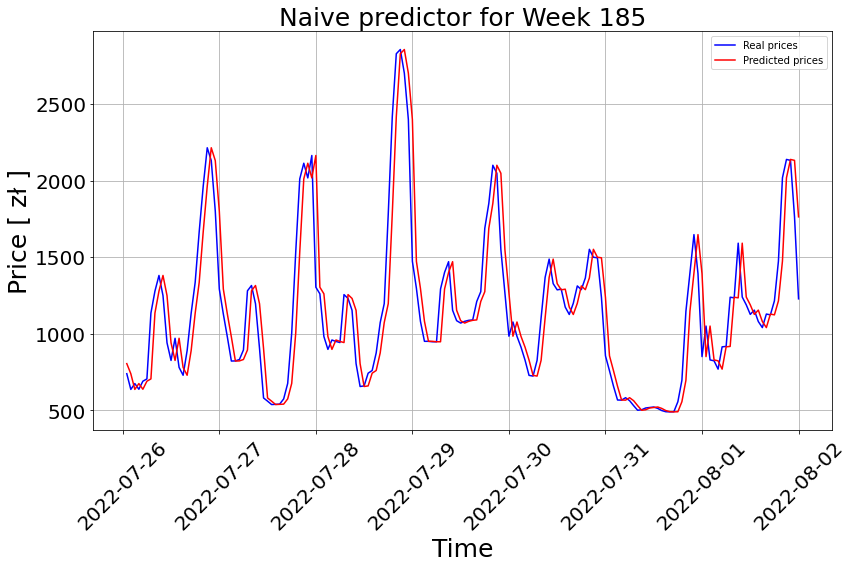

In [290]:
plot_prediction(Y_test, X_test[['Weeks_Since_Start', 'MEP-1']], 185, 'Naive predictor')

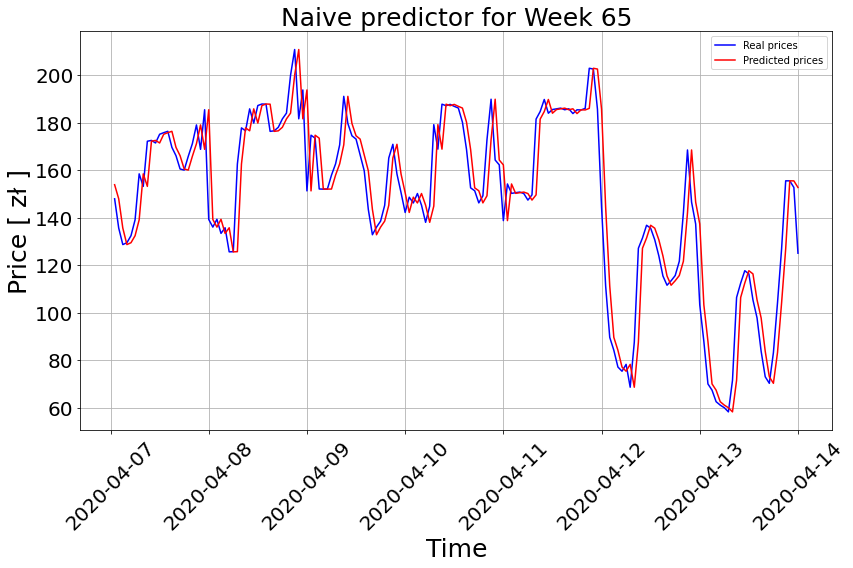

In [291]:
plot_prediction(Y_test, X_test[['Weeks_Since_Start', 'MEP-1']], 65, 'Naive predictor')

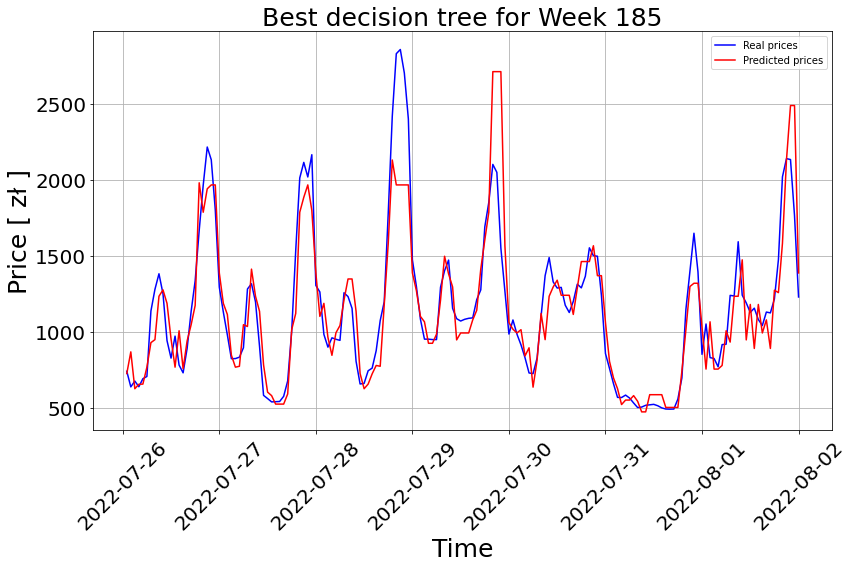

In [292]:
plot_prediction(Y_test, y_pred_dt_df, 185, 'Best decision tree')

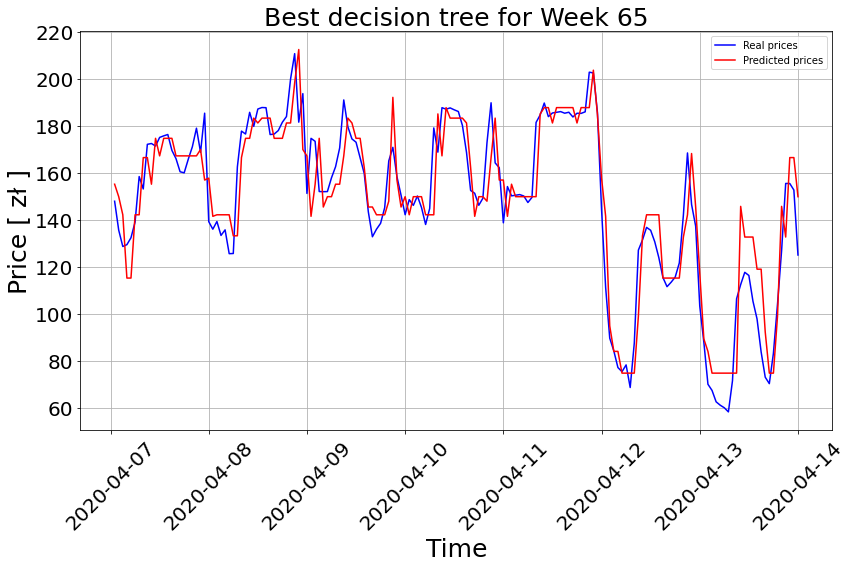

In [293]:
plot_prediction(Y_test, y_pred_dt_df, 65, 'Best decision tree')

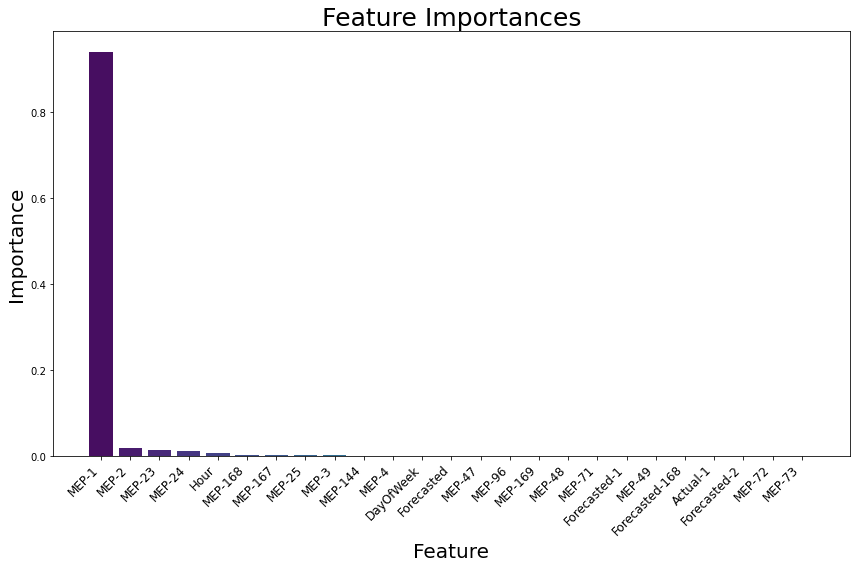

In [303]:
plot_importances(best_dt, x_train)

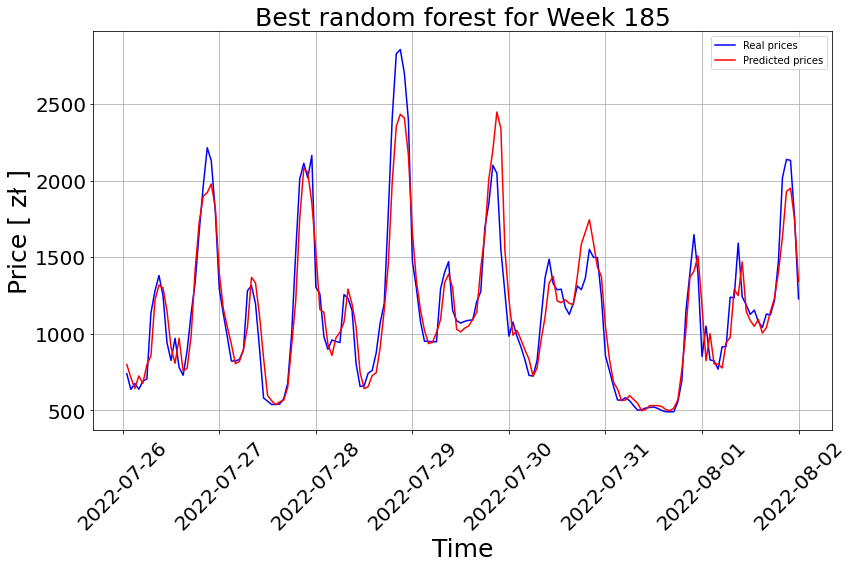

In [295]:
plot_prediction(Y_test, y_pred_rf_df, 185, 'Best random forest')

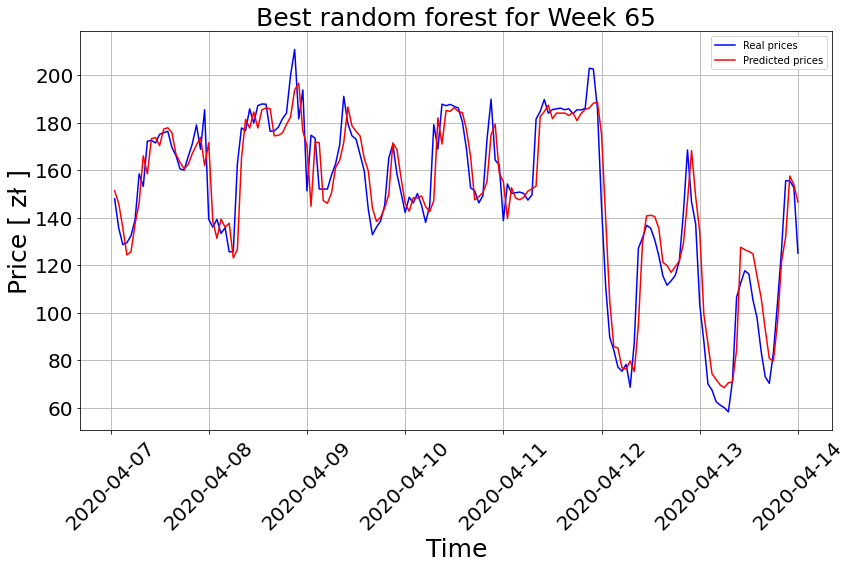

In [296]:
plot_prediction(Y_test, y_pred_rf_df, 65, 'Best random forest')

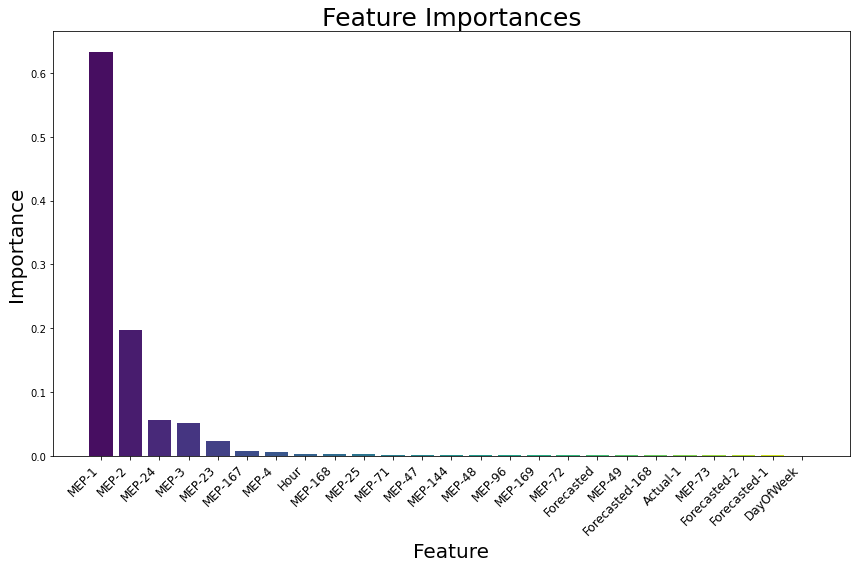

In [304]:
plot_importances(best_rf, x_train)

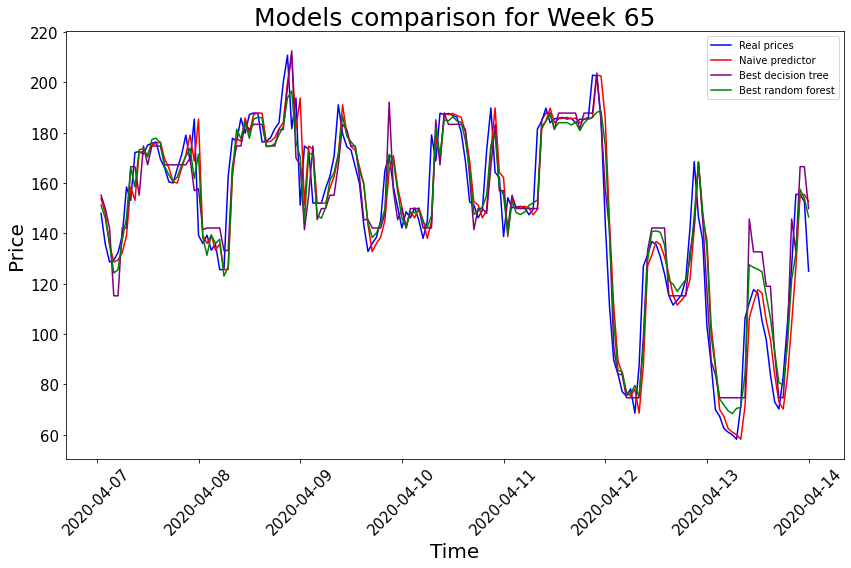

In [212]:
plot_comparison(Y_test, X_test['MEP-1'], y_pred_dt_df.iloc[:, 1], y_pred_rf_df.iloc[:, 1], 65, 'Models comparison')

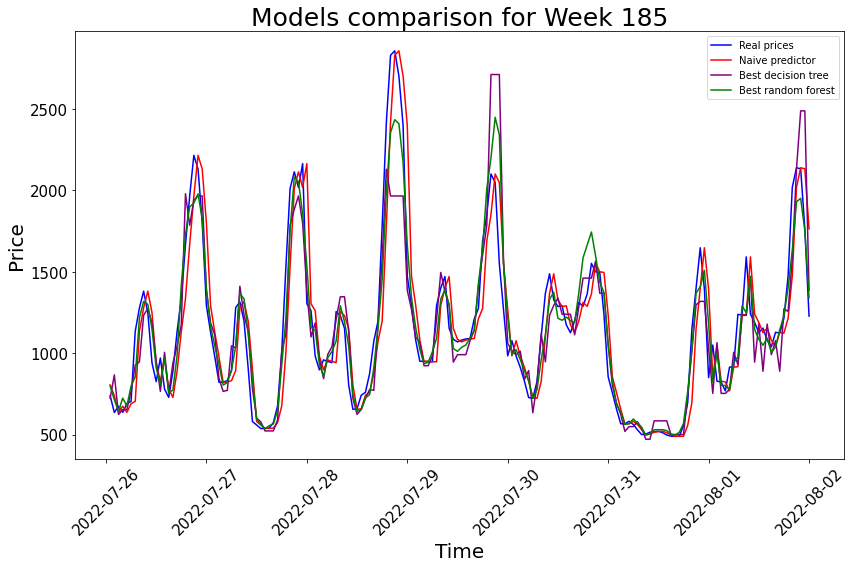

In [213]:
plot_comparison(Y_test, X_test['MEP-1'], y_pred_dt_df.iloc[:, 1], y_pred_rf_df.iloc[:, 1], 185, 'Models comparison')

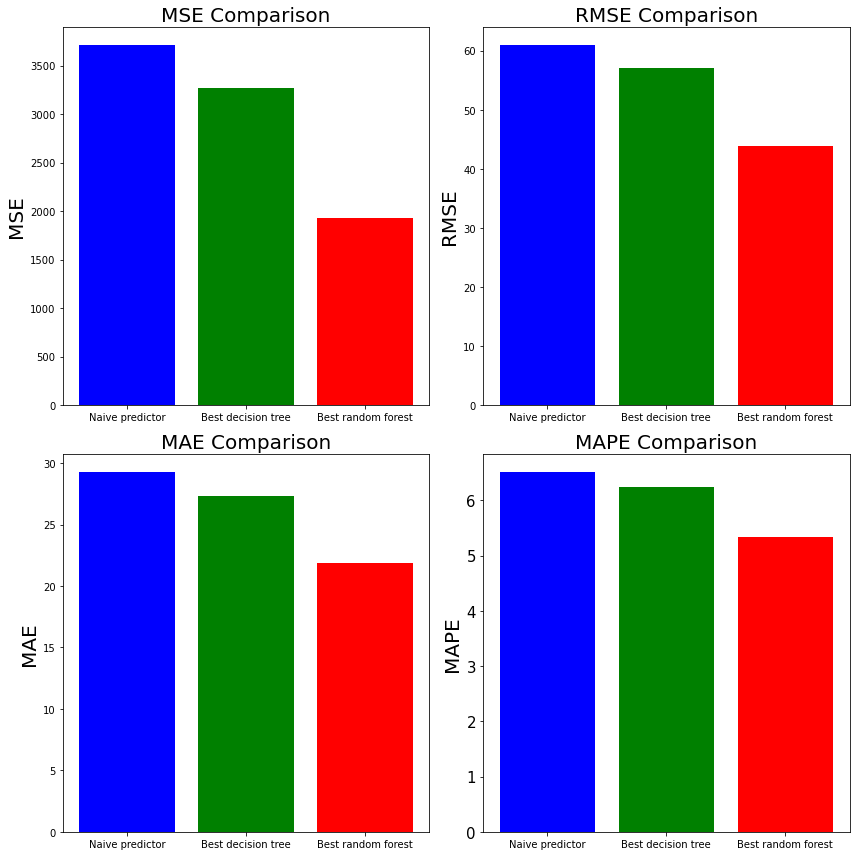

In [335]:
compare_model_performance(Y_test['MEP'], X_test['MEP-1'], y_pred_dt, y_pred_rf)

# 7. Analiza na dzień do przodu

## 7.1 Preparing the data

In [306]:
data = pd.read_csv('data/full_data.csv', sep=',',encoding='ANSI')
data['Date'] = pd.to_datetime(data2['Date'], format='%Y%m%d')
print(data.info())
print(data.shape)
print(data.keys())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        43824 non-null  datetime64[ns]
 1   Hour        43824 non-null  int64         
 2   MEP         43824 non-null  float64       
 3   DayOfWeek   43824 non-null  int64         
 4   Forecasted  43824 non-null  int64         
 5   Actual      43824 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 2.0 MB
None
(43824, 6)
Index(['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'Actual'], dtype='object')


In [307]:
shift_hours = [24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169]
for hours in shift_hours:
    data[f'MEP-{hours}'] = data['MEP'].shift(hours)

for hours in shift_hours:
    data[f'Actual-{hours}'] = data['Actual'].shift(hours)
for hours in shift_hours:
    data[f'Forecasted-{hours}'] = data['Forecasted'].shift(hours)

In [308]:
data = data.dropna()
data = data.drop(columns=['Actual'])

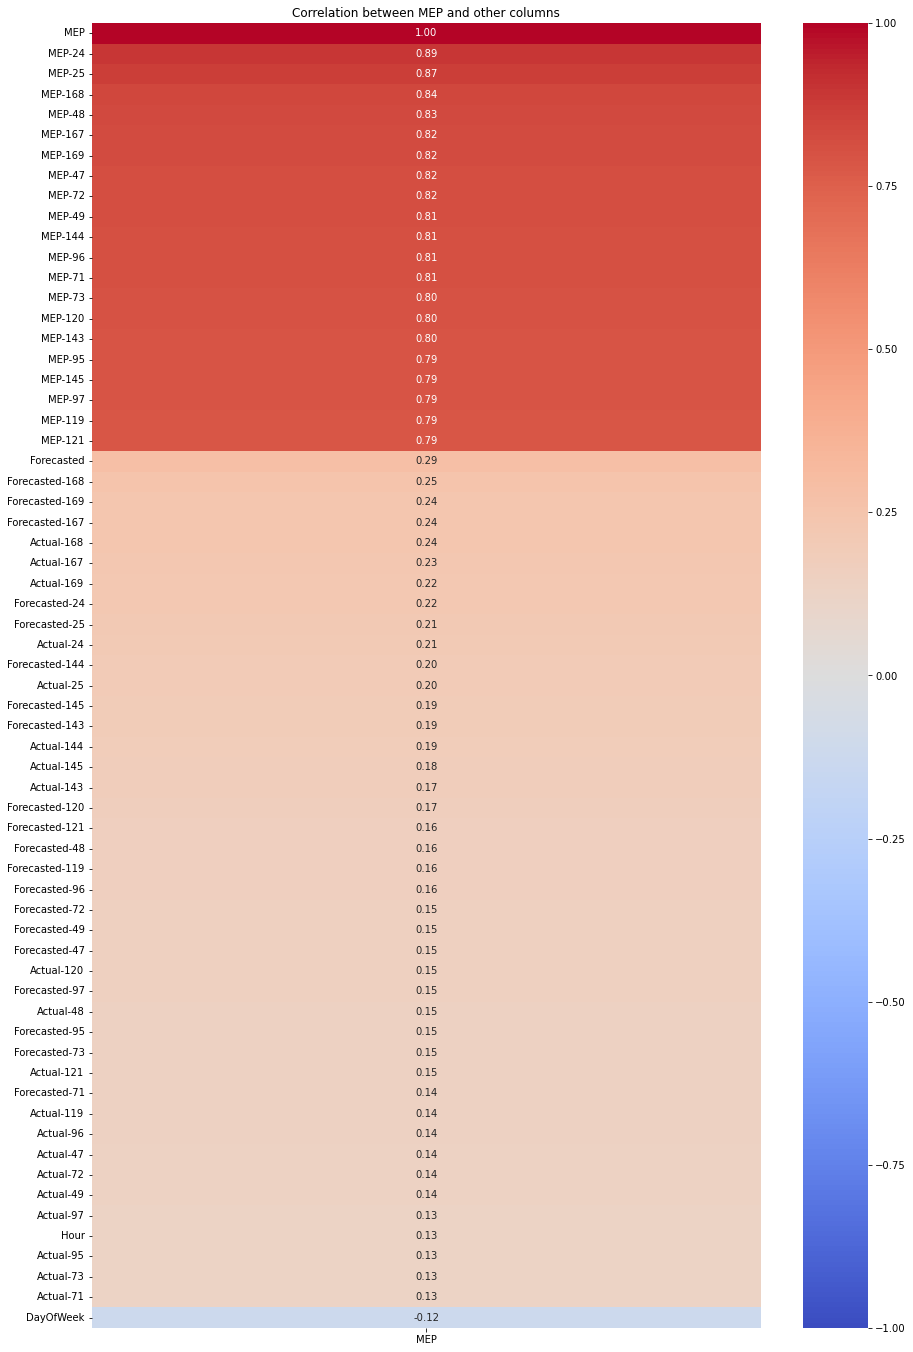

In [309]:
corr_matrix = data.corr()

mep_correlations = corr_matrix[['MEP']].sort_values(by='MEP', ascending=False)

plt.figure(figsize=(15, 24))
sns.heatmap(mep_correlations, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between MEP and other columns')
plt.show()

In [310]:
column_names = data.columns.tolist()

print(column_names)

['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-24', 'MEP-25', 'MEP-47', 'MEP-48', 'MEP-49', 'MEP-71', 'MEP-72', 'MEP-73', 'MEP-95', 'MEP-96', 'MEP-97', 'MEP-119', 'MEP-120', 'MEP-121', 'MEP-143', 'MEP-144', 'MEP-145', 'MEP-167', 'MEP-168', 'MEP-169', 'Actual-24', 'Actual-25', 'Actual-47', 'Actual-48', 'Actual-49', 'Actual-71', 'Actual-72', 'Actual-73', 'Actual-95', 'Actual-96', 'Actual-97', 'Actual-119', 'Actual-120', 'Actual-121', 'Actual-143', 'Actual-144', 'Actual-145', 'Actual-167', 'Actual-168', 'Actual-169', 'Forecasted-24', 'Forecasted-25', 'Forecasted-47', 'Forecasted-48', 'Forecasted-49', 'Forecasted-71', 'Forecasted-72', 'Forecasted-73', 'Forecasted-95', 'Forecasted-96', 'Forecasted-97', 'Forecasted-119', 'Forecasted-120', 'Forecasted-121', 'Forecasted-143', 'Forecasted-144', 'Forecasted-145', 'Forecasted-167', 'Forecasted-168', 'Forecasted-169']


In [311]:
selected_columns = ['Date', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-24', 'MEP-25', 'MEP-168', 'MEP-48', 'MEP-167', 'MEP-169', 'MEP-47', 'MEP-72', 'MEP-49', 'MEP-144', 'MEP-96', 'MEP-71', 'Forecasted-168', 'Forecasted-169', 'Actual-168', 'Actual-167']
data = data[selected_columns]

In [312]:
start_date = data['Date'].min()
data.loc[:, 'Weeks_Since_Start'] = (data['Date'] - start_date).dt.days // 7

data.loc[:, 'Cycle_Group'] = data['Weeks_Since_Start'] // 6

data.loc[:, 'Week_In_Cycle'] = data['Weeks_Since_Start'] % 6

data.loc[:, 'Set'] = 0
data.loc[data['Week_In_Cycle'] == 4, 'Set'] = 1
data.loc[data['Week_In_Cycle'] == 5, 'Set'] = 2

data = data.drop(columns=['Cycle_Group', 'Week_In_Cycle'])
selected_columns = ['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'MEP', 'DayOfWeek', 'Forecasted', 'MEP-24', 'MEP-25', 'MEP-168', 'MEP-48', 'MEP-167', 'MEP-169', 'MEP-47', 'MEP-72', 'MEP-49', 'MEP-144', 'MEP-96', 'MEP-71', 'Forecasted-168', 'Forecasted-169', 'Actual-168', 'Actual-167']
data = data[selected_columns]

In [313]:
y_pred_n = X_test['MEP-1']

In [314]:
Y = data[['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'MEP']]
X = data[['Set', 'Date', 'Weeks_Since_Start', 'Hour', 'DayOfWeek', 'Forecasted', 'MEP-24', 'MEP-25', 'MEP-168', 'MEP-48', 'MEP-167', 'MEP-169', 'MEP-47', 'MEP-72', 'MEP-49', 'MEP-144', 'MEP-96', 'MEP-71', 'Forecasted-168', 'Forecasted-169', 'Actual-168', 'Actual-167']]

In [315]:
Y_train = Y[Y['Set'] == 0].drop(columns=['Set'])
Y_val = Y[Y['Set'] == 1].drop(columns=['Set'])
Y_test = Y[Y['Set'] == 2].drop(columns=['Set'])
X_train = X[X['Set'] == 0].drop(columns=['Set'])
X_val = X[X['Set'] == 1].drop(columns=['Set'])
X_test = X[X['Set'] == 2].drop(columns=['Set'])

In [316]:
y_train = Y_train['MEP']
y_test = Y_test['MEP']
y_val = Y_val['MEP']
x_train = X_train.iloc[:, 2:]
x_test = X_test.iloc[:, 2:]
x_val = X_val.iloc[:, 2:]

## 7.2 Making the predictions

In [251]:
param_grid = {
        'max_depth': [9, 10, 11, 12, 13, 15],
        'min_samples_split': [14, 16, 20, 30],
        'min_samples_leaf': [10, 12, 18],
        'criterion': ['squared_error', 'friedman_mse'],
        'max_features': [0.6, 0.7, 0.8, 0.9],
        'max_leaf_nodes': [800, 1000, 1200, 1400]
}
y_pred_dt_df_24, y_pred_dt_24, best_dt_24, grid_dt_24 = decision_tree(param_grid, x_train, x_val, y_train, y_val)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 9, 'max_features': 0.7, 'max_leaf_nodes': 800, 'min_samples_leaf': 12, 'min_samples_split': 14}
Execution time: 100.39721989631653 seconds


In [253]:
param_grid = {
    'n_estimators': [160, 200],
    'max_depth': [10, 11, 12],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [3, 5, 6],
    'criterion': ['squared_error'],
    'max_features': [0.5, 0.55, 0.6],
    'max_leaf_nodes': [600, 800, 1000],
    'max_samples': [0.55, 0.6]
}
y_pred_rf_df_24, y_pred_rf_24, best_rf_24, grid_rf_24 = random_forest(param_grid, x_train, x_val, y_train, y_val)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.55, 'max_leaf_nodes': 600, 'max_samples': 0.6, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 160}
Execution time: 2393.0902695655823 seconds


## 7.3 Results

In [262]:
print('Naive predictor:')
print(score_the_model(Y_test['MEP'], X_test['MEP-24']))
print('Best decision tree:')
print(score_the_model(y_test, y_pred_dt_24))
print('Best random forest:')
print(score_the_model(y_test, y_pred_rf_24))

Naive predictor:
(17325.959898048175, 131.62811211154013, 75.2140434662237, 22.351641865650862)
Best decision tree:
(14149.226855509258, 118.9505227206222, 66.2718110224474, 19.963974281272353)
Best random forest:
(10792.419159662713, 103.88656871637792, 57.81738844915189, 18.03825032434197)


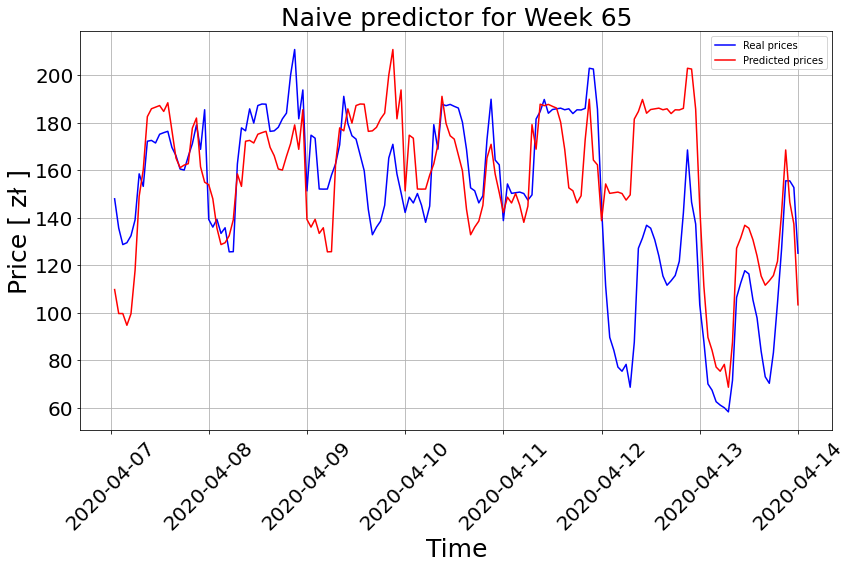

In [263]:
plot_prediction(Y_test, X_test[['Weeks_Since_Start', 'MEP-24']], 65, 'Naive predictor')

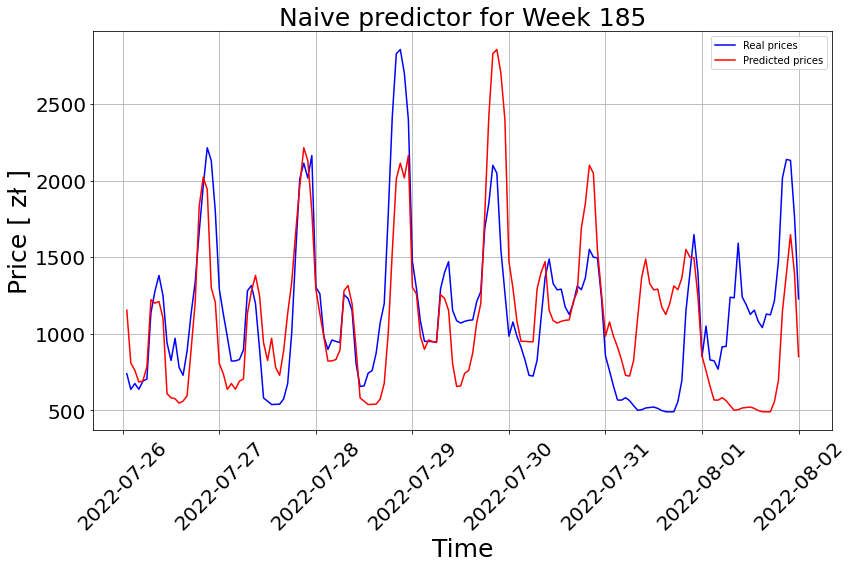

In [264]:
plot_prediction(Y_test, X_test[['Weeks_Since_Start', 'MEP-24']], 185, 'Naive predictor')

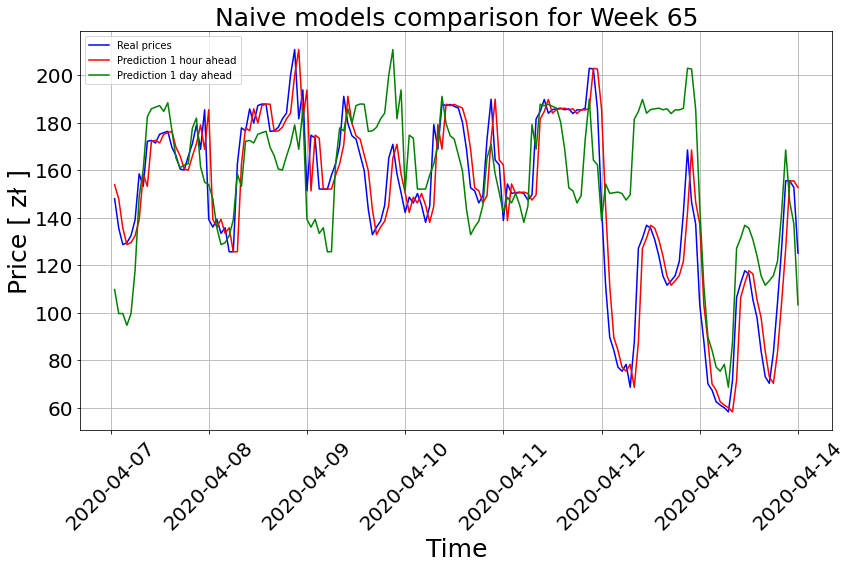

In [265]:
plot_time_comparison(Y_test, y_pred_n, X_test['MEP-24'], 65, 'Naive models comparison')

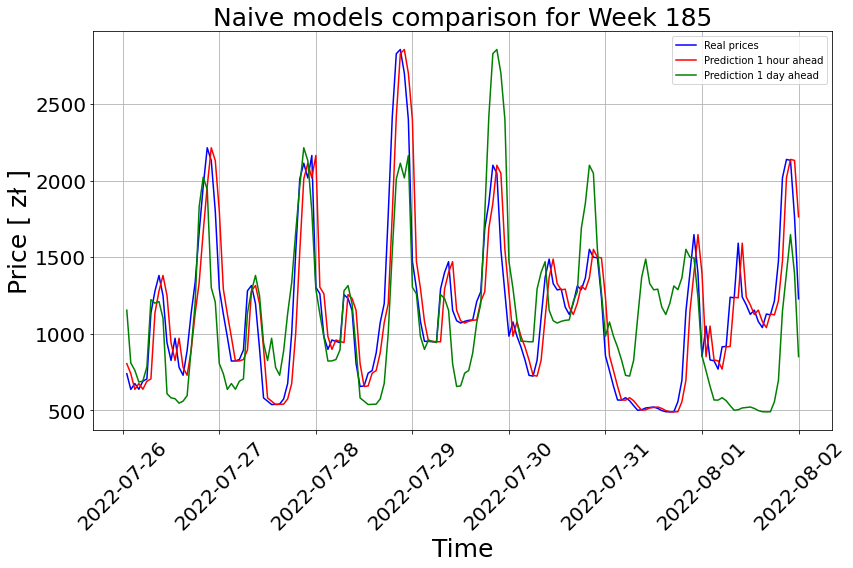

In [266]:
plot_time_comparison(Y_test, y_pred_n, X_test['MEP-24'], 185, 'Naive models comparison')

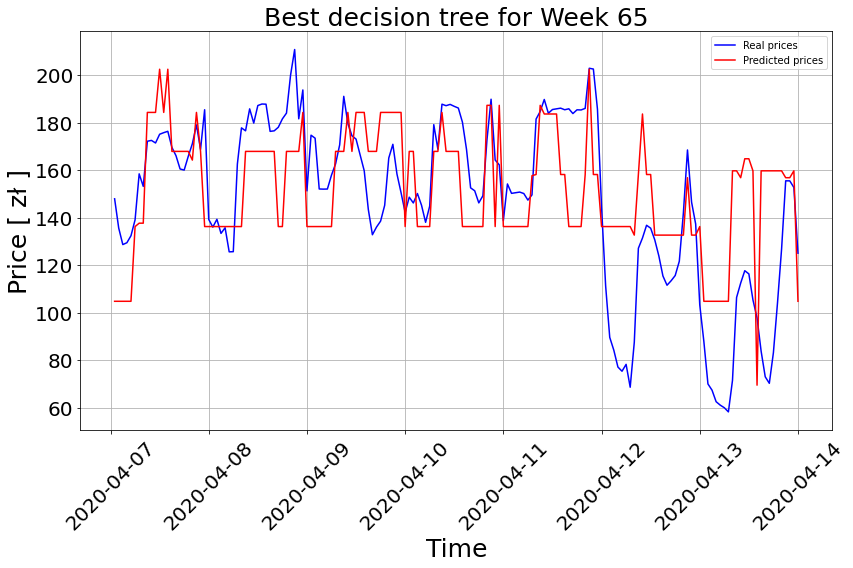

In [267]:
plot_prediction(Y_test, y_pred_dt_df_24, 65, 'Best decision tree')

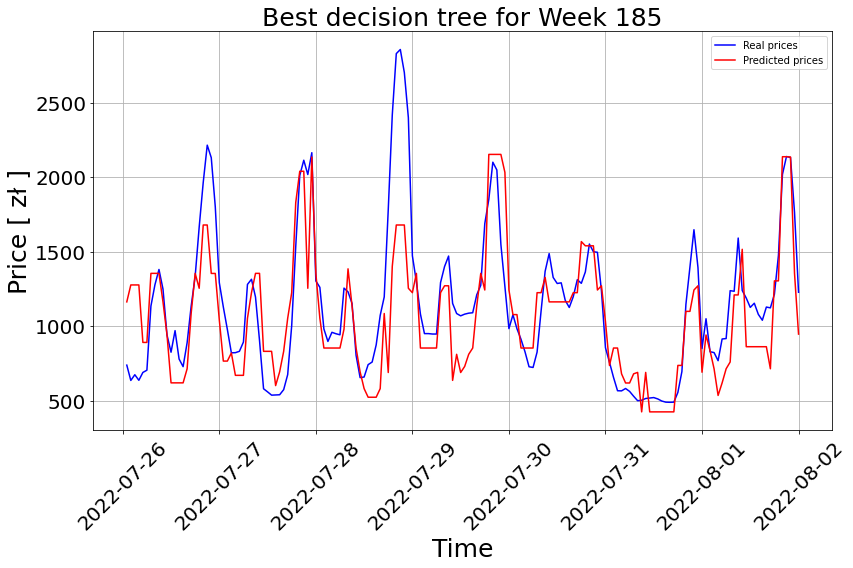

In [268]:
plot_prediction(Y_test, y_pred_dt_df_24, 185, 'Best decision tree')

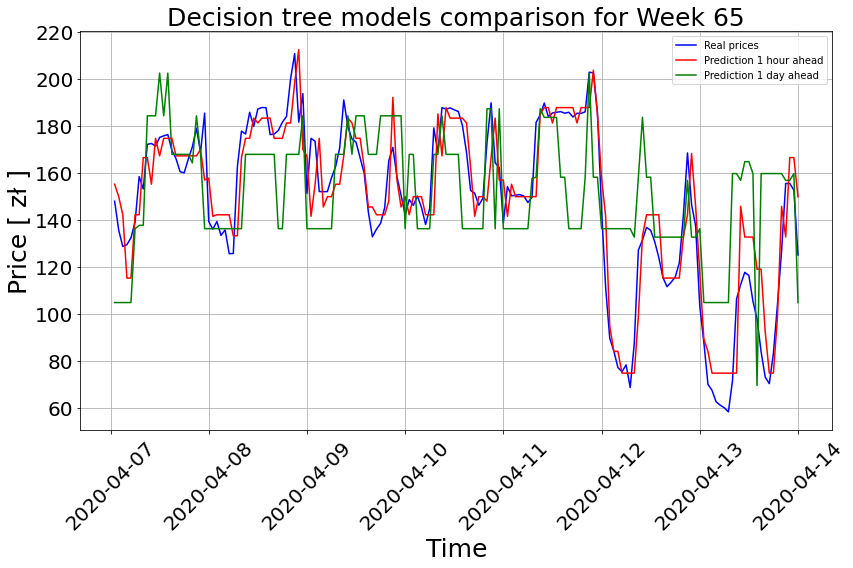

In [269]:
plot_time_comparison(Y_test, y_pred_dt_df.iloc[:, 1], y_pred_dt_df_24.iloc[:, 1], 65, 'Decision tree models comparison')

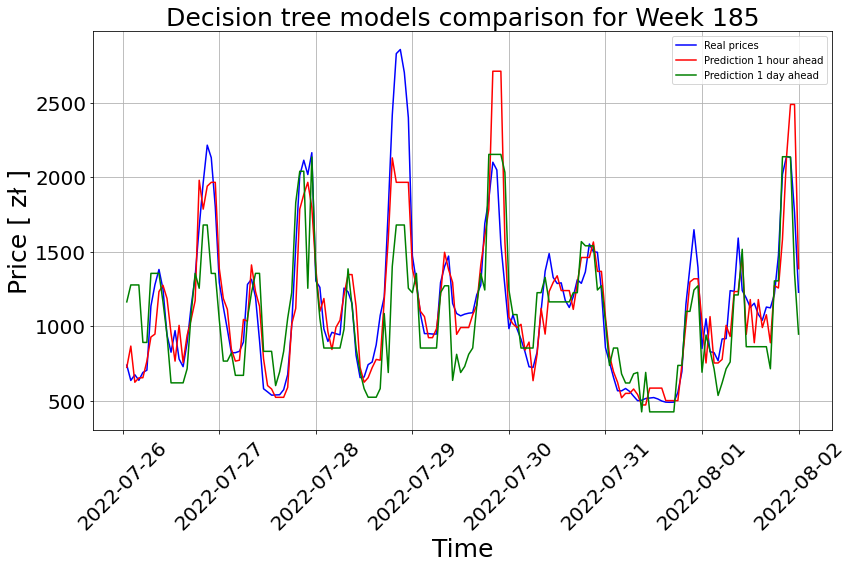

In [270]:
plot_time_comparison(Y_test, y_pred_dt_df.iloc[:, 1], y_pred_dt_df_24.iloc[:, 1], 185, 'Decision tree models comparison')

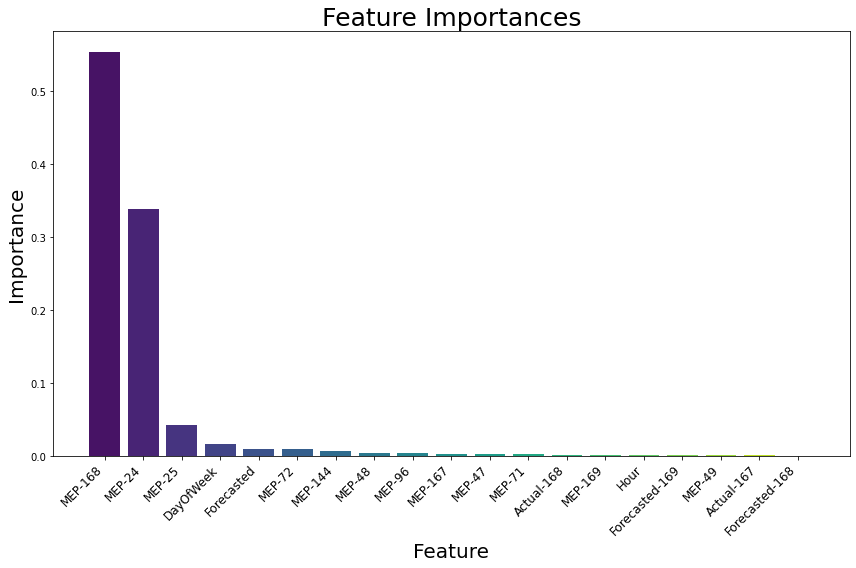

In [317]:
plot_importances(best_dt_24, x_train)

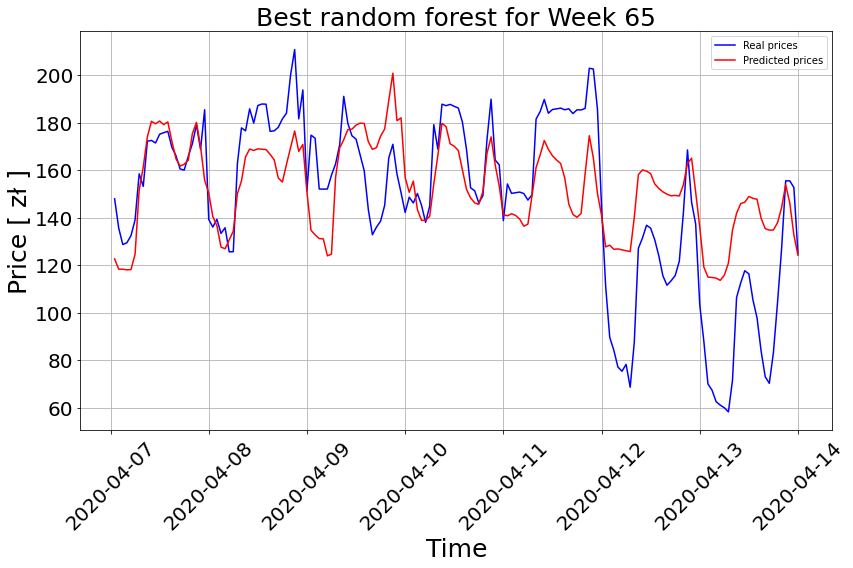

In [272]:
plot_prediction(Y_test, y_pred_rf_df_24, 65, 'Best random forest')

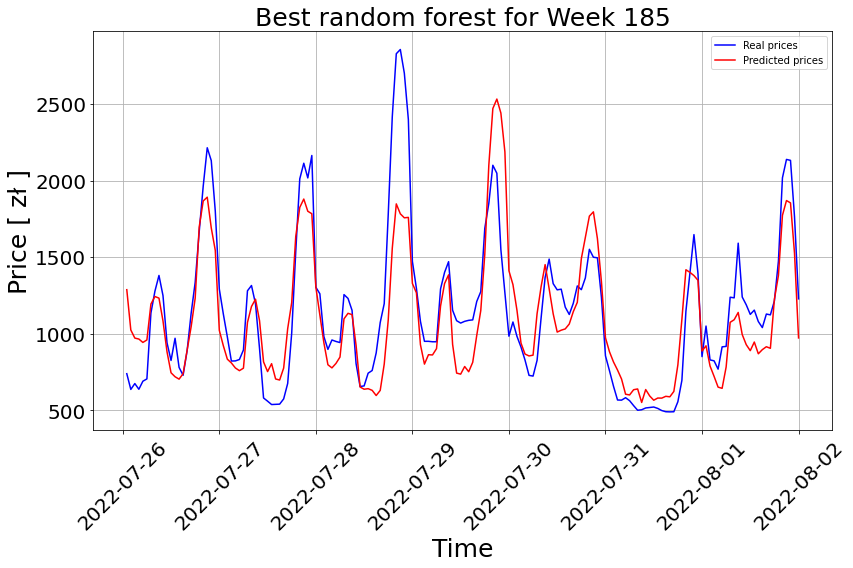

In [273]:
plot_prediction(Y_test, y_pred_rf_df_24, 185, 'Best random forest')

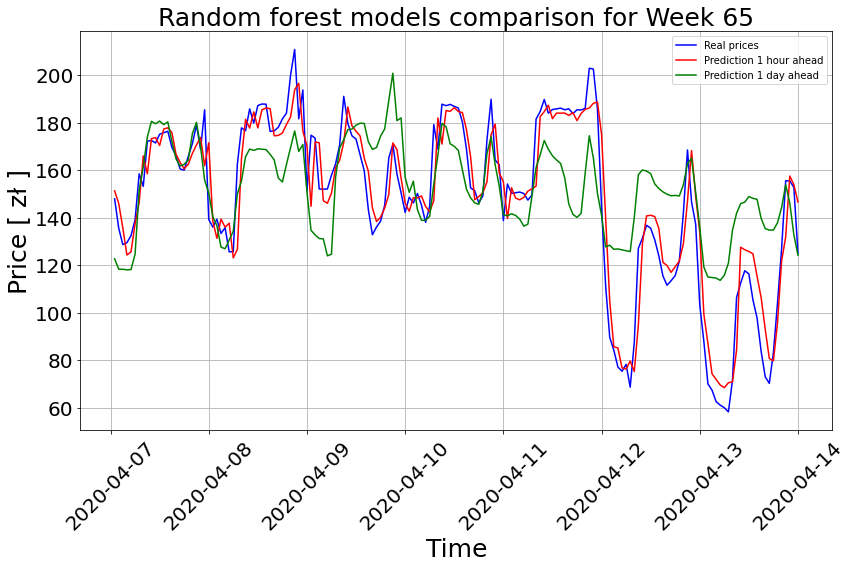

In [274]:
plot_time_comparison(Y_test, y_pred_rf_df.iloc[:, 1], y_pred_rf_df_24.iloc[:, 1], 65, 'Random forest models comparison')

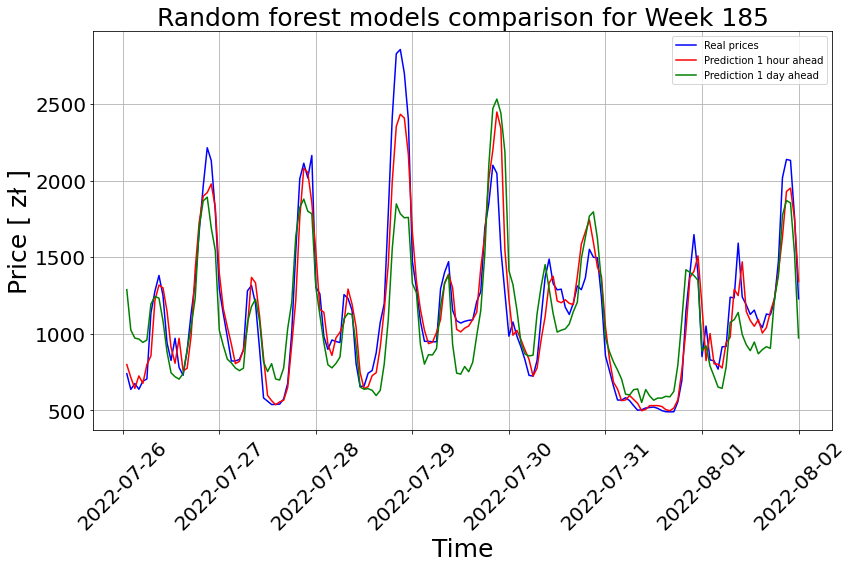

In [275]:
plot_time_comparison(Y_test, y_pred_rf_df.iloc[:, 1], y_pred_rf_df_24.iloc[:, 1], 185, 'Random forest models comparison')

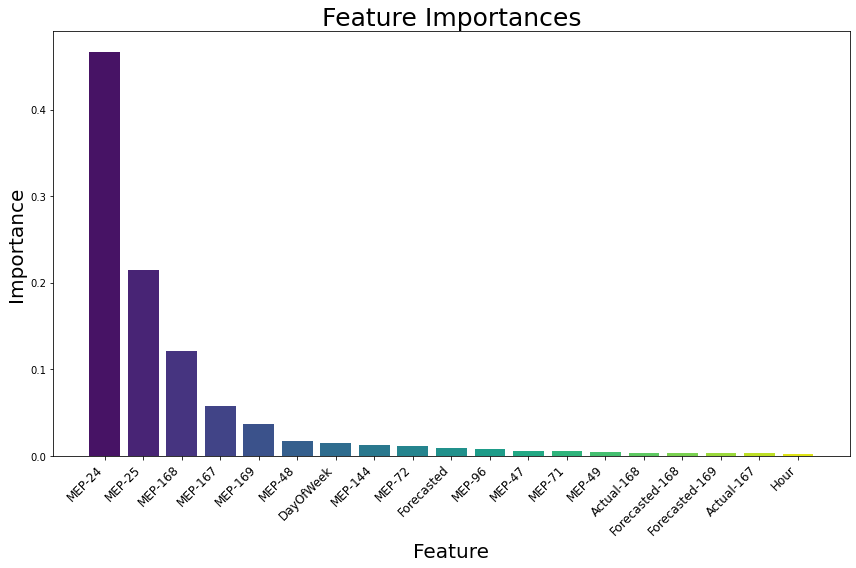

In [318]:
plot_importances(best_rf_24, x_train)

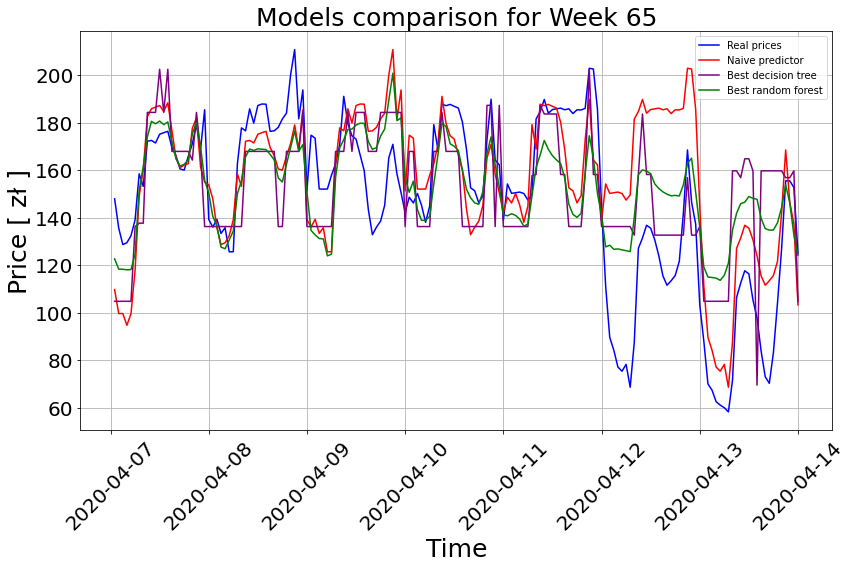

In [277]:
plot_comparison(Y_test, X_test['MEP-24'], y_pred_dt_df_24.iloc[:, 1], y_pred_rf_df_24.iloc[:, 1], 65, 'Models comparison')

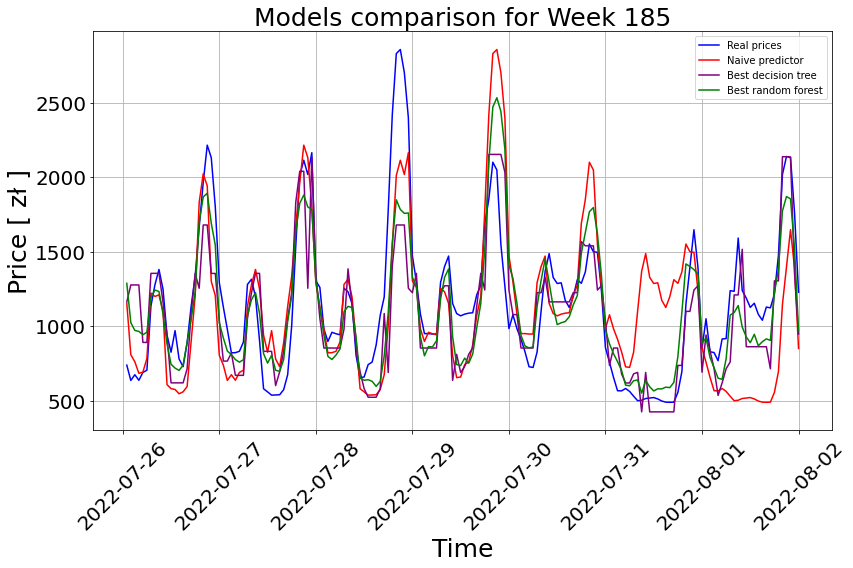

In [278]:
plot_comparison(Y_test, X_test['MEP-24'], y_pred_dt_df_24.iloc[:, 1], y_pred_rf_df_24.iloc[:, 1], 185, 'Models comparison')

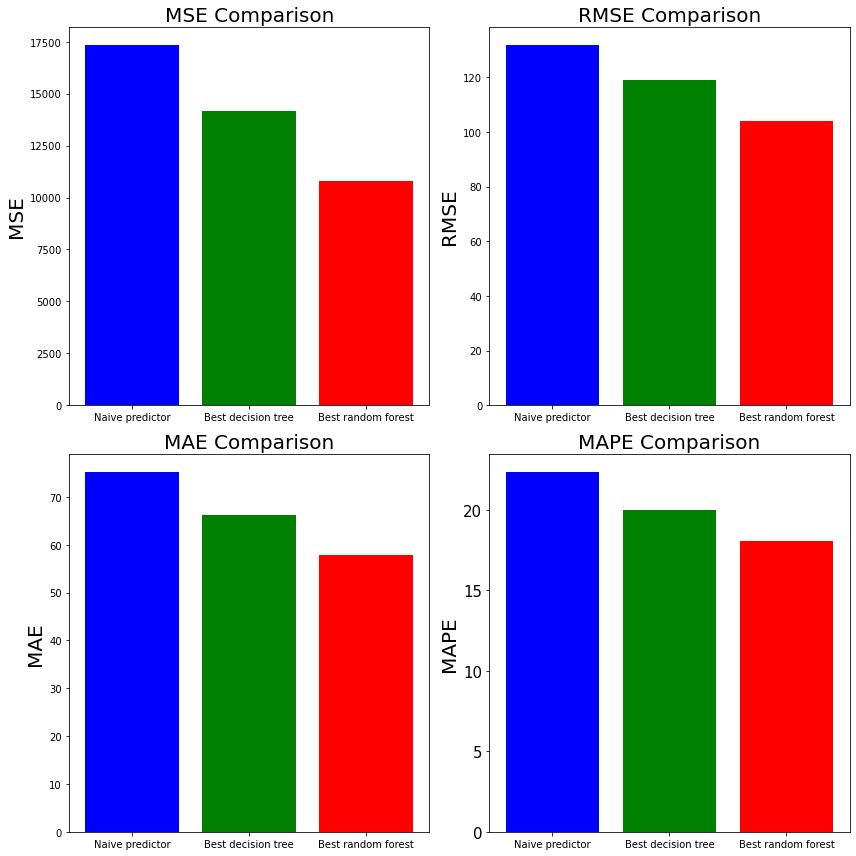

In [321]:
compare_model_performance(Y_test['MEP'], X_test['MEP-24'], y_pred_dt_24, y_pred_rf_24)

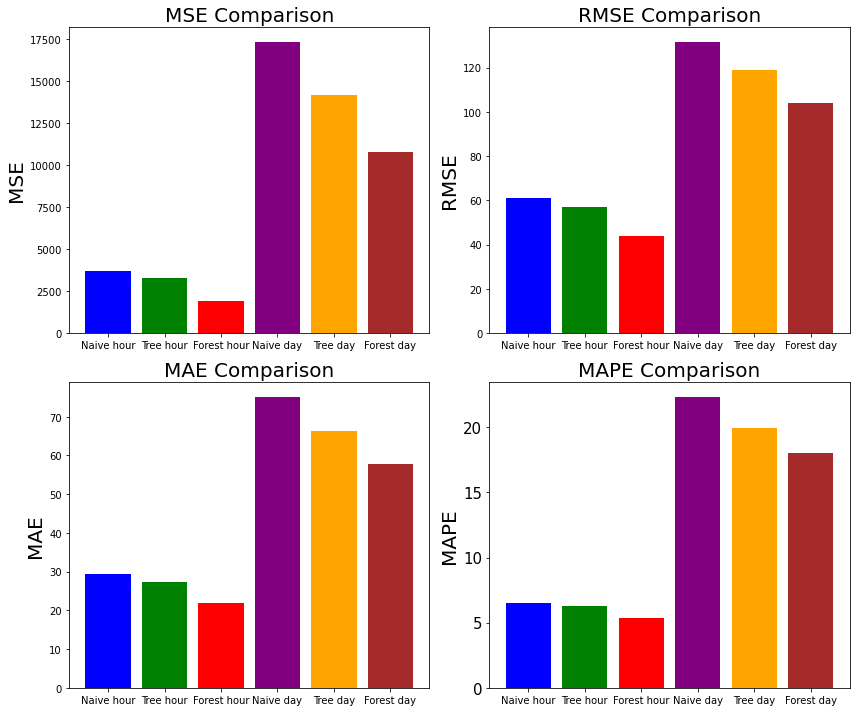

In [323]:
compare_model_performance_time(Y_test['MEP'], y_pred_n, y_pred_dt, y_pred_rf, X_test['MEP-24'], y_pred_dt_24, y_pred_rf_24)